<a href="https://colab.research.google.com/github/daniela-estevez/ProyectoIntegrador/blob/main/Avance3_13Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avance 3. Baseline

## Equipo 13

## Alejandro García Hernández A01793812
## Daniela Estevez Rodriguez A01793723
## Carlos Alberto López Álvarez A01168193

## Objetivos

Para esta etapa del proyecto, el objetivo es contar con una base óptima para que el(los) modelo(s) tengan el mejor rendimiento posible. Así, en esta etapa el trabajo se centra en seleccionar las variables que, a nuestro criterio, aporten mayor información, de ser necesesario se puede optar con construir nuevas características a partir de las ya existentes, reducir la cardinalidad de la base, etc. Con lo anterior, también se mitiga el riesgo de características sesgadas o correlacionadas y con ello, se puede acelerar la convergencia de los modelos seleccionados.

## 0. Librerías

In [1]:
# Librerías a utilizar para el pre procesamiento.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder

In [2]:
# Librerías para la sección de modelos supervisados
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score, classification_report, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder

In [81]:
# Librerías adicionales para la sección de modelos no-supervisados
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [3]:
# El siguiente bloque se agregó para poder leer los archivos drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Proyecto Integrador

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador


## 1. Preprocesamiento

In [4]:
data = pd.read_csv("base.csv",sep=",", encoding="latin1")
df= data.copy()

### 1.1 Depuración de características

In [5]:
# Para tener en mente la base inicial, observamos que cuenta con 380 renglones,
# 115 características y las etiquetas

print(f"Hay {df.shape[0]} filas y {df.shape[1]} columnas.")

Hay 380 filas y 116 columnas.


#### 1.1.1 Características irrelevantes por el origen de información contenida

Como se observó en el primer avance del proyecto existen algunas características que pueden eliminarse dado que el contenido de las mismas es irrelevante para el actual estudio. Dichas caracteristicas son:

-> Nombre y residencia. Ya que no dan información relevante.

-> fecha_nacimiento y fecha_1er_visita. Ya que esta información esta contenida en edad_1er_visita.

-> FECHA_INICIO_ACTUAL_EPISODIO. Ya que esta información está contenida en EDAD_INICIO_1er_EPISODIO.


In [6]:
# Eliminamos entonces estas características
df = df.drop(["Nombre","residencia","fecha_nacimiento","fecha_1er_visita","FECHA_INICIO_ACTUAL_EPISODIO"], axis=1)

#### 1.1.2 Características con datos faltantes

Se eliminarán todas las características que solo contengan valores nulos

In [7]:
#Eliminamos las columnas vacias
df = df.dropna(axis=1, how='all')

Si bien, existen diversos métodos para imputar valores faltantes en la base, esta imputación es peligrosa y puede sesgar los resultados si se realiza en variables en donde la mayoría de sus resgistros reportan valores faltantes, ya que los datos imputados podrían no ser representativos de la verdadera distribución de los datos. Por lo anterior es conveniente eliminar aquellas características en donde al menos el 40% de sus valores son nulos.

In [8]:
# Calculamos el porcentaje de valores nulos en cada columna
null_percentage = (df.isnull().sum() / len(df)) * 100

# Con el sguiente código, se crea un DataFrame con los porcentajes de valores nulos
null_df = pd.DataFrame({'Columna': null_percentage.index, 'Porcentaje_Null': null_percentage.values})

# Filtramos el DataFrame para mantener solo las columnas donde el porcentaje de valores nulos sea menor al 40%
columnas_a_mantener = null_df[null_df['Porcentaje_Null'] < 40]['Columna']

# Filtramos el DataFrame original para mantener solo las columnas que queremos conservar
df = df[columnas_a_mantener]

In [9]:
#Observamos que hasta este momento hemos eliminado ya 44 características
print(f"Hay {df.shape[0]} filas y {df.shape[1]} columnas.")

Hay 380 filas y 72 columnas.


#### 1.1.3 Variables que reportan el mismo valor en todos sus registros

De igual forma, en el primer avance del proyecto, observamos variables que reportan un solo valor en todos los registros. Dado que estas características no aportarán ninguna información al modelo, deben de eliminarse

In [10]:
#Primero obtenemos las variables que reportan un solo valor y mostramos sus nombres
unique_counts = df.nunique()
columnas_a_eliminar = unique_counts[unique_counts == 1].index
columnas_a_eliminar

Index(['A4_MALESTAR_PROBLEMAS_RELACIONES_INTERPERSONALES',
       'CONDUCTA_SUICIDA_REMISION_TEMPRANA',
       'B4_VOCES_SUEniOS_INTENCION_SUICIDA', 'B6_PENSO_MEDIO_SUICIDARSE',
       'B7_PENSO_LUGAR_SUICIDIO', 'B9_PENSO_FINALIZAR_ALGO_ANTES_SUICIDIO',
       'B11_INTENSION_MORIR_EN_SUICIDIO',
       'B12_NECESIDAD_MORIR_ANTES_PLAN_SUICIDIO',
       'B13_DIFICULTAD_RESISTIR_IMPULSO_SUICIDIO', 'B14_INTENTO_MORIR',
       'B14a_INICIO_ACCIONES_INTENTO_SUICIDIO',
       'B14b_INICIO_ACCIONES_INTENTO_SUICIDIO_SIN_LASTIMARSE',
       'B14c_INICIO_ACCIONES_INTENTO_SUICIDIO_LO_DETUVIERON',
       'B15_SE_LESIONO_SIN_SUICIDIO', 'B16_INTENTO_SUICIDARSE',
       'B16a_COMENZO_INTENTO_SUICIDIO_SIN_FINANALIZAR',
       'B16b_COMENZO_INTENTO_SUICIDIO_LO_INTERRUMPIERON',
       'B16c_TERMINO_INTENTO_SUICIDIO',
       'B17_TIEMPO_DEDICADO_A_PENSAMIENTO_SUICIDA',
       'B19_POSIBILIDAD_SUICIDARSE_TRES_MESES_SIGUIENTES',
       'B_tot_SI_ALGUNA_PREGUNTA_B'],
      dtype='object')

In [11]:
#y procedemos a elimnarlas de la base
df = df.drop(columns=columnas_a_eliminar)

In [12]:
#Observamos que ahora ya hemos eliminado 65 características
print(f"Hay {df.shape[0]} filas y {df.shape[1]} columnas.")

Hay 380 filas y 51 columnas.


### 1.2 Imputación de valores

#### 1.2.1 Corrección tipo de dato

In [13]:
binary_columns = []
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) == 2 and all(value in [0, 1] for value in unique_values):
        binary_columns.append(column)

# Número de columnas con solamente 0's o 1's
print("Numero de columnas binarias encontradas:", len(binary_columns))

Numero de columnas binarias encontradas: 28


In [14]:
# Actualizamos el tipo de las columnas binarias a booleano usando astype()
for column in binary_columns:
    df[column] = df[column].astype(bool)

In [15]:
# Lista de variables que son en realidad categóricas
cat_cols=["SEXO","CONDICION_ACTUAL","ESTADO_civil","RELIGION","PROVEEDOR_FAMILIAR","OCUPACIoN_JEFE_FAMILIA","ESCOLARIDAD__JEFE_FAMILIA",
         "ESCOLARIDAD_MAXIMA_PX","DX_PRIMARIO","CODIGO_DX.1","TRASTORNO_MAYOR_DIAGNOSTICO",
         "Riesgo_suicidio","Sintomas_ansiosos"]

# Actualizamos el tipo de las columnas categoricas usando astype()
for column in cat_cols:
    df[column] = df[column].astype("category")

In [16]:
# Actualizamos el tipo de la columna MENARCA a uno numérico usando astype()
df["MENARCA"] = df["MENARCA"].astype("float64")

-> Nos falta convertir las siguientes variables a entero pero no podemos convertirlas todavía por los NaN: EDAD_1era_visita,EDAD_INICIO_1er_EPISODIO,AnioS_ESTUDIO_PACIENTE,MENARCA,INICIO_VIDA_SEXUAL_ACTIVA,MADRS_TOTAL, CGI-S.1.

#### 1.2.2 Inputar valores

Ahora, será importante imputar los valores faltantes en aquellas variables que no fueron eliminadas pero si contenían valores nulos en alguno de sus registros. Para las características categoricas y booleanas se imputará la moda, mientras que para las valores numericas la imputación será con la mediana ya que hay varias distribuciones con sesgo.


*Para la variable MENARCA primero se sustituiran los valores en los registros donde SEXO es igual a M (masculino) por -1 ya que es correcto que este vacios.

In [17]:
# Imprimimos los valores de las variables categoricas para verificar que no hay errores
for c in df.select_dtypes(include='category').columns:
  print(c)
  print(df[c].unique())
  print("")

SEXO
['F', 'M']
Categories (2, object): ['F', 'M']

CONDICION_ACTUAL
['Primera aparición sin antecedente', 'Indistinguible del pasado', 'Recurrencia condición previa', NaN, 'Exageración de trastorno crónico', 'Significativamente diferente de condición pre...]
Categories (5, object): ['Exageración de trastorno crónico', 'Indistinguible del pasado',
                         'Primera aparición sin antecedente', 'Recurrencia condición previa',
                         'Significativamente diferente de condición pre...]

ESTADO_civil
['Soltero(a)', 'Casado(a)', NaN, 'Viudo(a)', 'Divorciado(a)', 'Unión libre', 'Separado(a)']
Categories (6, object): ['Casado(a)', 'Divorciado(a)', 'Separado(a)', 'Soltero(a)', 'Unión libre',
                         'Viudo(a)']

RELIGION
['Catolica', NaN, 'Ninguna', 'Evangelica ', 'Testigo de Jehova ', ..., 'Bautista', 'Ateo', 'Catolico no practicante', 'Metodista', 'Adventista del 7 día']
Length: 15
Categories (14, object): ['Adventista del 7 día', 'Ateo', 'Bau

Encontramos que TRASTORNO_MAYOR_DIAGNOSTICO tiene un valor 0. Como sabemos que todos los pacientes tienen algun diagnostico de un trastorno de depresión. Vamos a cambiar los 0 por la moda.

In [18]:
# Sustituir los valores de MENARCA donde SEXO es "M"
df["TRASTORNO_MAYOR_DIAGNOSTICO"].value_counts(normalize=True)

TRASTORNO_MAYOR_DIAGNOSTICO
0                                                  0.768421
TRASTORNO DEPRESIVO MAYOR RECIDIVANTE              0.131579
TRASTORNO DEPRESIVO MAYOR RECURRENTE               0.063158
TRASTORNO DEPRESIVO MAYOR RECURRENTE RESISTENTE    0.013158
TRASTORNO DEPRESIVO MAYOR EPISODIO UNICO           0.010526
TRASTORNO DEPRESIVO MAYOR RECURRENTE SEVERO        0.007895
TRASTORNO DEPRESIVO MAYOR                          0.002632
TRASTORNO DEPRESIVO MAYOR PRIMER EPISODIO          0.002632
Name: proportion, dtype: float64

PENDIENTE RESPUESTA DOCTOR PARA VER SI DEBE ELIMINARSE EL 0 O QUE SIGNIFICA

In [19]:
# Sustituir los valores de MENARCA donde SEXO es "M"
df.loc[df['SEXO'] == 'M', 'MENARCA'] = -1

# Imputar la moda a las variables numéricas
for columna in df.select_dtypes(include='number').columns:
    df[columna] = df[columna].fillna(df[columna].median())

# Imputar la moda a las variables booleanas
for columna in df.select_dtypes(include='bool').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

# Imputar la moda a las variables alfanuméricas
for columna in df.select_dtypes(include='category').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

In [20]:
# Lista de variables que son en realidad enteros
enteros_cols=["EDAD_1era_visita","EDAD_INICIO_1er_EPISODIO","AnioS_ESTUDIO_PACIENTE","MENARCA","INICIO_VIDA_SEXUAL_ACTIVA","MADRS_TOTAL","CGI-S.1"]

# Actualizamos el tipo de las columnas de enteros usando astype()
for column in enteros_cols:
    df[column] = df[column].astype("int64")

### 1.3 Problemas de multicolinealidad


Una correlación alta entre variables explicativas puede causarnos problemas para usar algunos modelos o para explicar los resultados.
<br>
Por tanto, en base al análisis realizado en la entrega dos, procedemos a eliminar las siguientes variables:

EPISODIO_MAYOR_total_vida, SUICIDALIDAD_ACTUAL, SUICIDALIDAD_INTENTO_total_vida, B1b_INTENCION_DE_MORIR_EN_ACCIDENTE, B5_PENSO_METODO_SUICIDARSE, B8_PENSO_FECHA_SUICIDIO, B10_INTENCION_SUICIDIO, B18_INTENTO_SUICIDARSE, B2_NECESIDAD_DE_ESTAR_MUERTO, TRASTORNO_MAYOR_PASADO

In [21]:
# Eliminamos estas características
df = df.drop(["EPISODIO_MAYOR_total_vida","SUICIDALIDAD_ACTUAL","SUICIDALIDAD_INTENTO_total_vida",
              "B1b_INTENCION_DE_MORIR_EN_ACCIDENTE","B5_PENSO_METODO_SUICIDARSE","B8_PENSO_FECHA_SUICIDIO",
              "B10_INTENCION_SUICIDIO","B18_INTENTO_SUICIDARSE","B2_NECESIDAD_DE_ESTAR_MUERTO","TRASTORNO_MAYOR_PASADO"],
             axis=1)

### 1.4 Variables que dan la misma información

Después de tener una reunión con los doctores llegamos a la conclusión de eliminar las siguientes variables:


-> CODIGO_DX.1, CODIGO_DX.2, CODIGO_DX.3. Ya que son el código correspondiente a los diagnósiticos contenidos en las variables DX.PRIMARIO, DX.SECUNDARIO, DX.TERCERIO, respectivamente.<br>
Nota: CODIGO_DX.2, CODIGO_DX.3 ya fueron eliminadas previamente.

-> Puntaje_experto. Ya que Puntaje_experto es la calificación optenida a partir de las preguntas sobre riesgo de suicidio de la MINI (preguntas B) y Riesgo_suicidio es la binarización realizada por los doctores de esas calificaciones, considerando que arriba de 10 es alto.

In [22]:
# Eliminamos estas características
df = df.drop(["CODIGO_DX.1","Puntaje_experto"],
             axis=1)

### 1.5 Outliers

In [23]:
# Function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column (numerical column)
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    # creating the 2 subplots

    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color="violet")
    # boxplot will be created and a star will indicate the mean value of the column

    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2)
    # For histogram

    ax_hist2.axvline(data[feature].mean(), color="green", linestyle="--")
    # Add mean to the histogram

    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")
    # Add median to the histogram

Realizaremos un análisis para revisar si hay valores que superen el umbral de estar después de 4 veces el rango intercuartil.

In [24]:
# Crea lista de columnas numéricas
num_col = df.select_dtypes(include='number').columns

# Inicializa lista de columnas con posibles valores atípicos
col_outliers = []

for colname in num_col:
    # Comprueba si un valor es más de 4 veces el rango intercuartil
    quartiles = np.quantile(df[colname], [0.25, 0.75])
    power_4iqr = 4 * (quartiles[1] - quartiles[0])
    print(colname)
    print(f"Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, 4*IQR = {power_4iqr}")
    outlier_screen_size = df.loc[
        np.abs(df[colname] - df[colname].median()) > power_4iqr, colname
    ]
    print(outlier_screen_size)
    print(
        f"Se encontraron {len(outlier_screen_size)} posibles outlieres de {df.shape[0]}"
    )
    # Check if a columns has potential outliers
    if len(outlier_screen_size) > 0:
        col_outliers.append(colname)
    print("\n\n")

print(f"Las columnas con posibles outliers son {col_outliers}")

EDAD_1era_visita
Q1 = 37.75, Q3 = 65.0, 4*IQR = 109.0
Series([], Name: EDAD_1era_visita, dtype: int64)
Se encontraron 0 posibles outlieres de 380



EDAD_INICIO_1er_EPISODIO
Q1 = 27.75, Q3 = 60.25, 4*IQR = 130.0
275    1955
Name: EDAD_INICIO_1er_EPISODIO, dtype: int64
Se encontraron 1 posibles outlieres de 380



AnioS_ESTUDIO_PACIENTE
Q1 = 6.75, Q3 = 15.0, 4*IQR = 33.0
Series([], Name: AnioS_ESTUDIO_PACIENTE, dtype: int64)
Se encontraron 0 posibles outlieres de 380



MENARCA
Q1 = -1.0, Q3 = 13.0, 4*IQR = 56.0
Series([], Name: MENARCA, dtype: int64)
Se encontraron 0 posibles outlieres de 380



INICIO_VIDA_SEXUAL_ACTIVA
Q1 = 19.0, Q3 = 22.0, 4*IQR = 12.0
11      1
31     35
35     44
46     40
50     37
53     42
57     39
59     58
71     33
77     33
186    38
271    33
282    37
310    37
Name: INICIO_VIDA_SEXUAL_ACTIVA, dtype: int64
Se encontraron 14 posibles outlieres de 380



CGI-S.1
Q1 = 4.0, Q3 = 5.0, 4*IQR = 4.0
Series([], Name: CGI-S.1, dtype: int64)
Se encontraron 0 posibl

Revisaremos las estadísticas y gráficas de las variables con posibles outliers.

In [25]:
pos_outliers=['EDAD_INICIO_1er_EPISODIO', 'INICIO_VIDA_SEXUAL_ACTIVA',
              'DURACION_EPISODIO_MAYOR_ACTUAL']

In [26]:
df[pos_outliers].describe()

,EDAD_INICIO_1er_EPISODIO,INICIO_VIDA_SEXUAL_ACTIVA,DURACION_EPISODIO_MAYOR_ACTUAL
count,380.000000,380.000000,380.000000
mean,48.636842,20.936842,33.186842
std,99.807941,4.824214,34.832344
min,8.000000,1.000000,0.000000
25%,27.750000,19.000000,12.000000
50%,42.000000,20.000000,24.000000
75%,60.250000,22.000000,45.000000
max,1955.000000,58.000000,300.000000


Conclusiones de valores atipicos

*   EDAD_INICIO_1er_EPISODIO: Se encuentra al menos un registro con edad de "1955". Se asume se trata de un valor erroneo.
*   INICIO_VIDA_SEXUAL_ACTIVA: No se observan minimos o másximo que que sugieran ser erroneos.
*   DURACION_EPISODIO_MAYOR_ACTUAL: No se observan minimos o másximo que que sugieran ser erroneos.

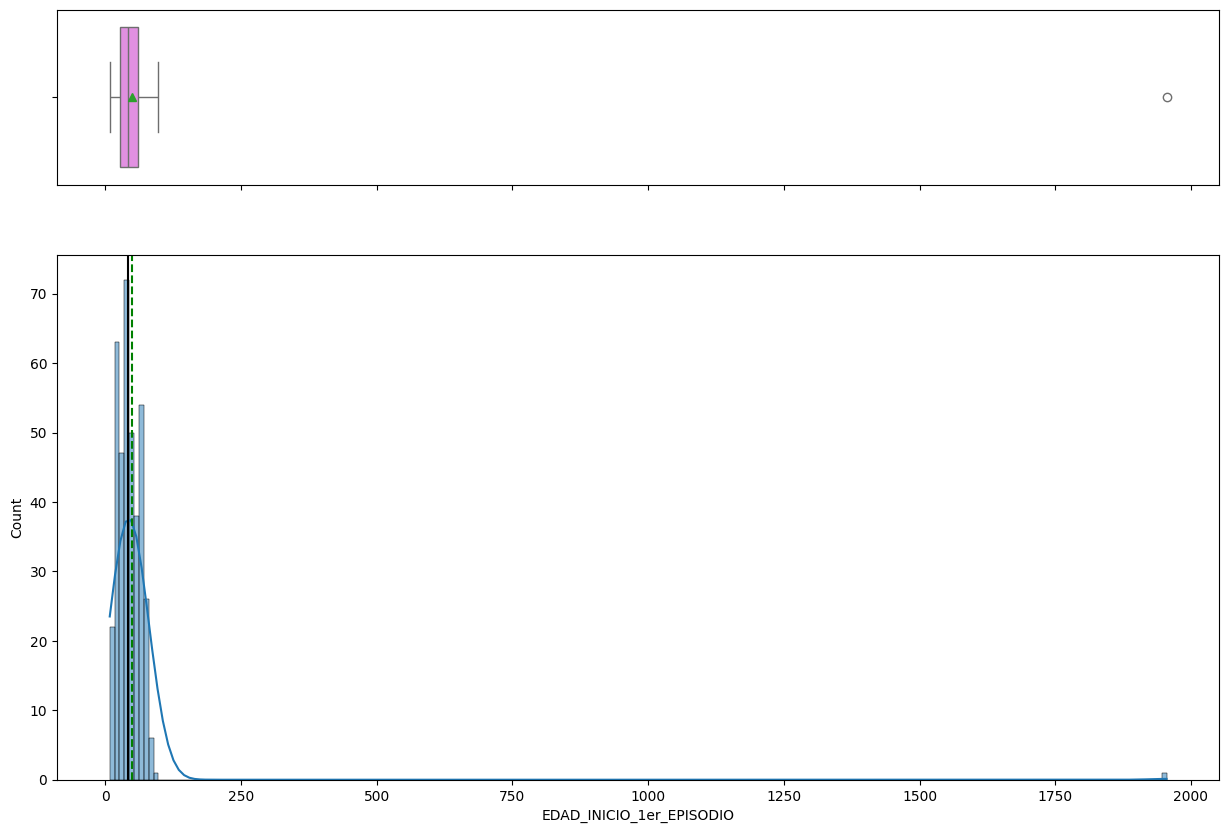

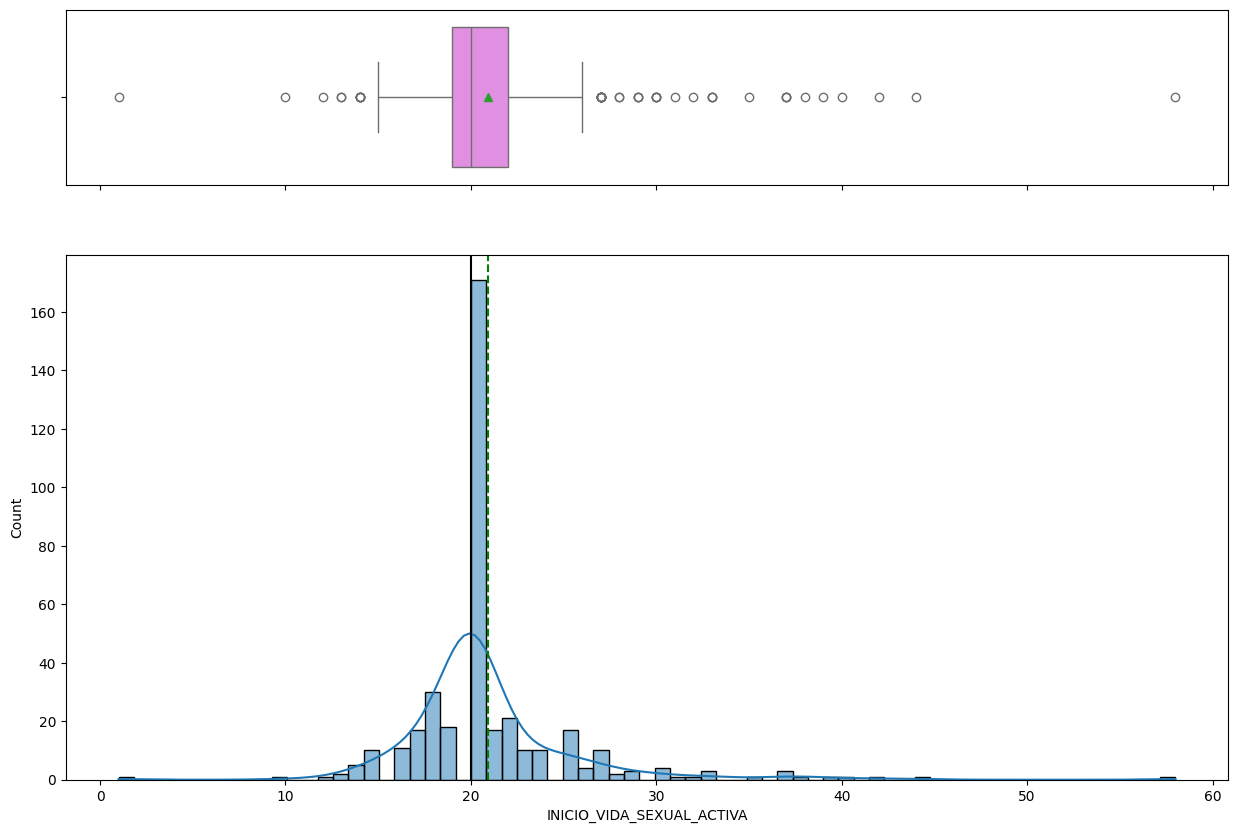

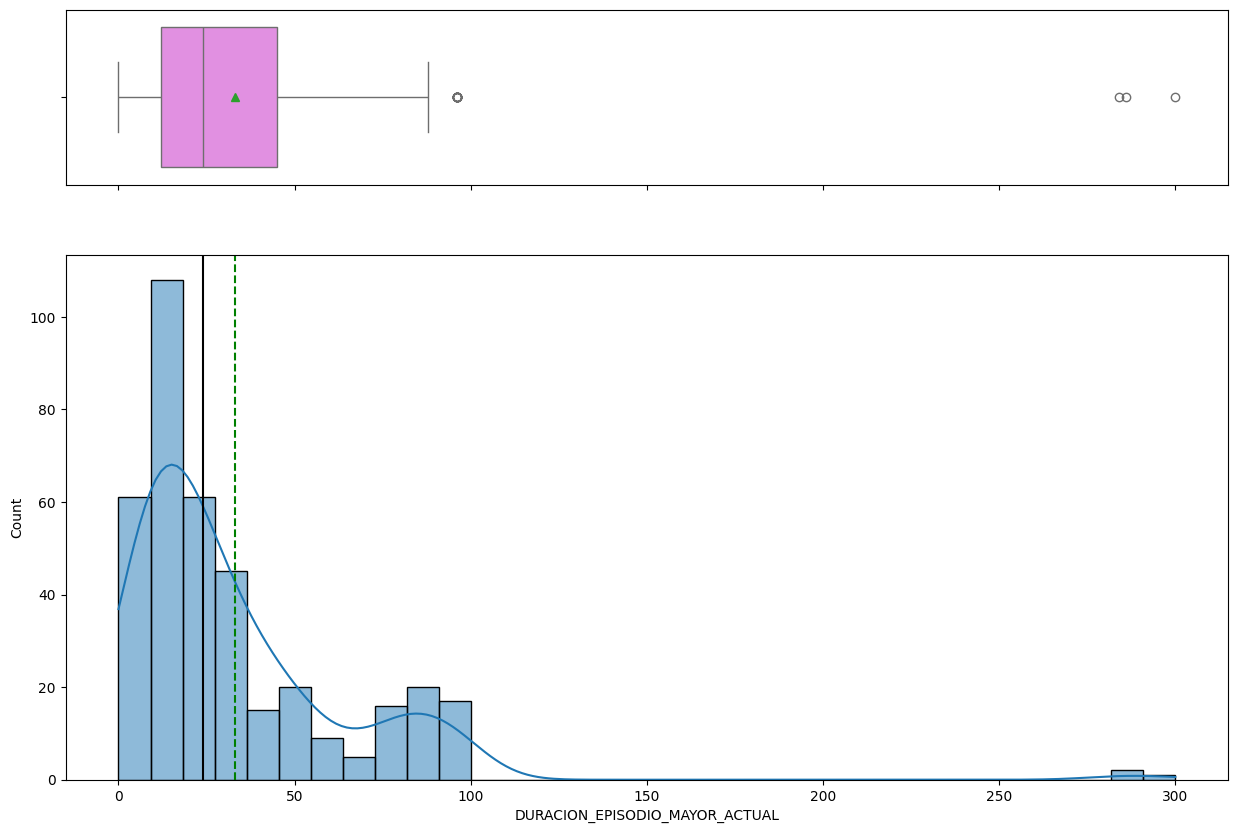

In [27]:
# Histograma y boxplot de la variables
for c in pos_outliers:
  histogram_boxplot(df, c, figsize=(15, 10), kde=True);

Notamos que las variables tienen un sesgo positivo, lo que significa que los outliers son valores mayores.

In [28]:
# Listado de outliers a la derecha
for c in pos_outliers:
  print(df[c].value_counts(normalize=True).sort_index(ascending=False))
  print("")

EDAD_INICIO_1er_EPISODIO
1955    0.002632
96      0.002632
86      0.005263
82      0.002632
80      0.007895
          ...   
13      0.002632
12      0.005263
11      0.005263
10      0.007895
8       0.005263
Name: proportion, Length: 74, dtype: float64

INICIO_VIDA_SEXUAL_ACTIVA
58    0.002632
44    0.002632
42    0.002632
40    0.002632
39    0.002632
38    0.002632
37    0.007895
35    0.002632
33    0.007895
32    0.002632
31    0.002632
30    0.010526
29    0.007895
28    0.005263
27    0.026316
26    0.010526
25    0.044737
24    0.026316
23    0.026316
22    0.055263
21    0.044737
20    0.450000
19    0.047368
18    0.078947
17    0.044737
16    0.028947
15    0.026316
14    0.013158
13    0.005263
12    0.002632
10    0.002632
1     0.002632
Name: proportion, dtype: float64

DURACION_EPISODIO_MAYOR_ACTUAL
300    0.002632
286    0.002632
284    0.002632
96     0.044737
88     0.002632
86     0.026316
84     0.021053
83     0.002632
79     0.013158
78     0.002632
75     0.00

Conclusiones de valores atipicos

*   EDAD_INICIO_1er_EPISODIO: Se encuentra un registro erroneo con edad de "1955". Se procede a sustituir el valor por la mediana.
*   INICIO_VIDA_SEXUAL_ACTIVA: Se encuentra un registro erroneo con incio de vida sexual activa en 1. Se procede a sustituir el valor por la mediana. Sobre el resto de los outliers intentaremos realizar una transformación.
*   DURACION_EPISODIO_MAYOR_ACTUAL: No se encuentran valores que sugieran ser erroneos. Se intentara realizar alguna trasnformación para tratar de no perder la inforamción.

In [29]:
# Reemplazar el valor 1955 por la mediana
df['EDAD_INICIO_1er_EPISODIO'] = df['EDAD_INICIO_1er_EPISODIO'].replace(1955, df['EDAD_INICIO_1er_EPISODIO'].median())

# Reemplazar el valor 1 por la mediana
df['INICIO_VIDA_SEXUAL_ACTIVA'] = df['INICIO_VIDA_SEXUAL_ACTIVA'].replace(1, df['INICIO_VIDA_SEXUAL_ACTIVA'].median())

In [30]:
# Realizamos una copia del df para realizar una trasnformación
df_T=df.copy()

**Winsonorización:** Reemplaza los valores atípicos con valores en el percentil p-ésimo o (1 - p)-ésimo para reducir su impacto sin eliminarlos.

In [31]:
# Transformamos las variables usando Winsonorización
df_T['INICIO_VIDA_SEXUAL_ACTIVA_W'] = winsorize(df_T['INICIO_VIDA_SEXUAL_ACTIVA'], limits=(0.05, 0.05))
df_T['DURACION_EPISODIO_MAYOR_ACTUAL_W'] = winsorize(df_T['DURACION_EPISODIO_MAYOR_ACTUAL'], limits=(0.05, 0.05))

In [32]:
# Crea lista de columnas numéricas
num_col = df_T.select_dtypes(include='number').columns

# Inicializa lista de columnas con posibles valores atípicos
col_outliers = []

for colname in num_col:
    # Comprueba si un valor es más de 4 veces el rango intercuartil
    quartiles = np.quantile(df_T[colname], [0.25, 0.75])
    power_4iqr = 4 * (quartiles[1] - quartiles[0])
    print(colname)
    print(f"Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, 4*IQR = {power_4iqr}")
    outlier_screen_size = df_T.loc[
        np.abs(df_T[colname] - df_T[colname].median()) > power_4iqr, colname
    ]
    print(outlier_screen_size)
    print(
        f"Se encontraron {len(outlier_screen_size)} posibles outlieres de {df_T.shape[0]}"
    )
    # Check if a columns has potential outliers
    if len(outlier_screen_size) > 0:
        col_outliers.append(colname)
    print("\n\n")

print(f"Las columnas con posibles outliers son {col_outliers}")

EDAD_1era_visita
Q1 = 37.75, Q3 = 65.0, 4*IQR = 109.0
Series([], Name: EDAD_1era_visita, dtype: int64)
Se encontraron 0 posibles outlieres de 380



EDAD_INICIO_1er_EPISODIO
Q1 = 27.75, Q3 = 60.0, 4*IQR = 129.0
Series([], Name: EDAD_INICIO_1er_EPISODIO, dtype: int64)
Se encontraron 0 posibles outlieres de 380



AnioS_ESTUDIO_PACIENTE
Q1 = 6.75, Q3 = 15.0, 4*IQR = 33.0
Series([], Name: AnioS_ESTUDIO_PACIENTE, dtype: int64)
Se encontraron 0 posibles outlieres de 380



MENARCA
Q1 = -1.0, Q3 = 13.0, 4*IQR = 56.0
Series([], Name: MENARCA, dtype: int64)
Se encontraron 0 posibles outlieres de 380



INICIO_VIDA_SEXUAL_ACTIVA
Q1 = 19.75, Q3 = 22.0, 4*IQR = 9.0
9      10
31     35
34     30
35     44
46     40
50     37
53     42
57     39
59     58
62     30
71     33
77     33
185    32
186    38
193    30
227    31
232    30
271    33
282    37
310    37
Name: INICIO_VIDA_SEXUAL_ACTIVA, dtype: int64
Se encontraron 20 posibles outlieres de 380



CGI-S.1
Q1 = 4.0, Q3 = 5.0, 4*IQR = 4.0
Seri

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


None


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


None


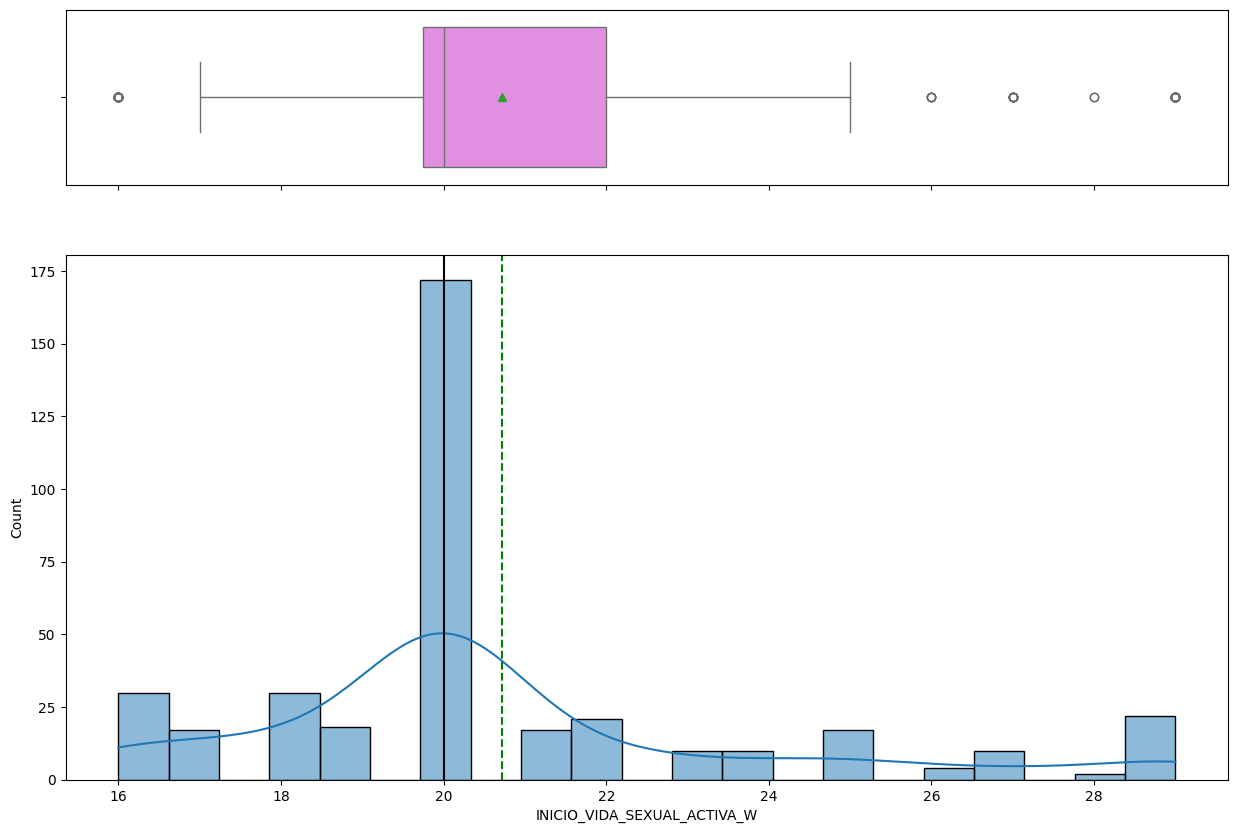

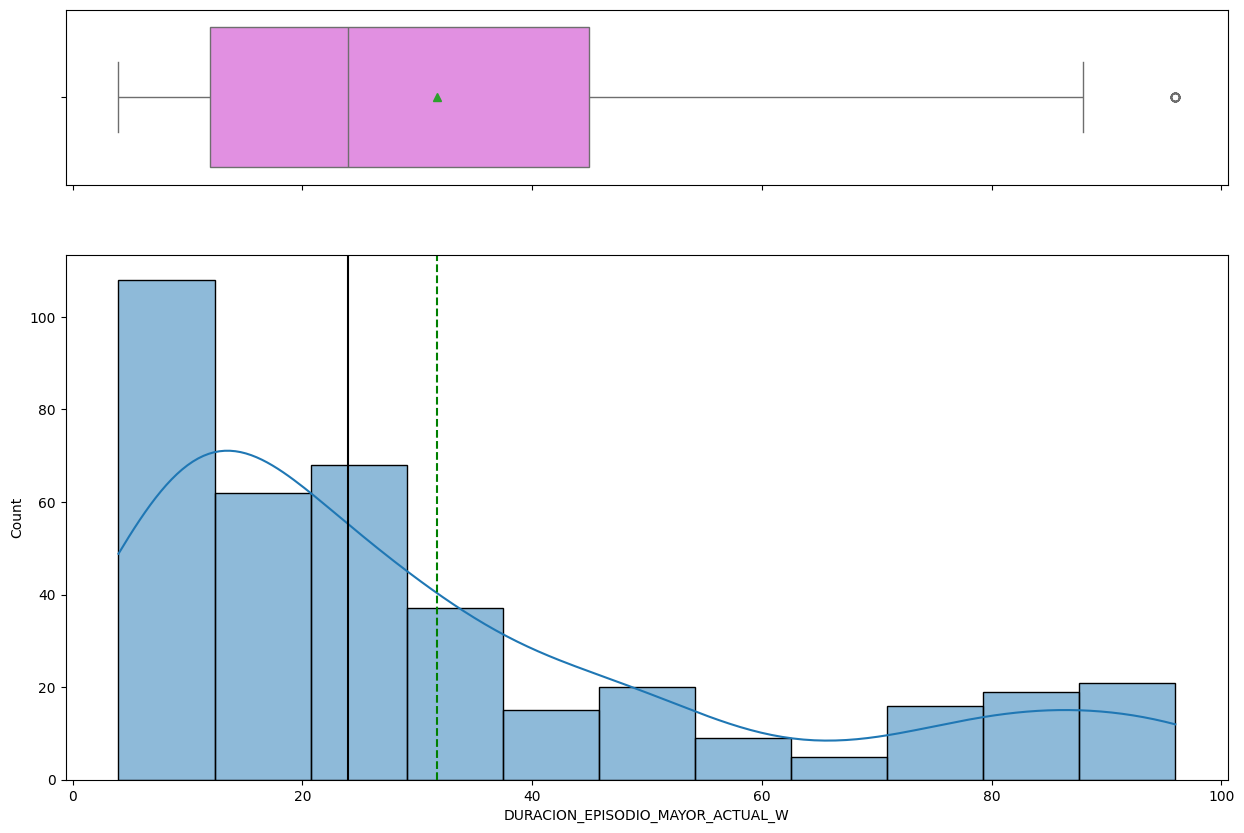

In [33]:
# Histograma y boxplot de la variables
print(histogram_boxplot(df_T, "INICIO_VIDA_SEXUAL_ACTIVA_W", figsize=(15, 10), kde=True))
print(histogram_boxplot(df_T, "DURACION_EPISODIO_MAYOR_ACTUAL_W", figsize=(15, 10), kde=True))

Obsevamos que logramos minimizar el problema de los outliers. Procedemos a eliminar las variables originales en el dataframe df_transform

In [34]:
# Eliminamos estas características originales
df_T = df_T.drop(["INICIO_VIDA_SEXUAL_ACTIVA","DURACION_EPISODIO_MAYOR_ACTUAL"],
             axis=1)

### 1.6 Codificación variables

In [35]:
# Hacemos listas de las variables ordinales
cat_orginales= ['ESCOLARIDAD__JEFE_FAMILIA', 'ESCOLARIDAD_MAXIMA_PX', 'DX_PRIMARIO','TRASTORNO_MAYOR_DIAGNOSTICO',
                'Riesgo_suicidio','Sintomas_ansiosos']

#### 1.6.1 Variables Ordinales

In [36]:
# Creamos una copia del dataframe
df_TC=df_T.copy()

In [37]:
# Crear el encoder ordinal
encoder_1 = OrdinalEncoder(categories=[["Menos de 6 años", "Primaria", "Secundaria", "Preparatoria",
                                     "Estudios universitarios no terminados", "Licenciatura", "Posgrado"]], dtype=int)
encoder_2 = OrdinalEncoder(categories=[["Distimia","Trastorno depresivo episodio único ",
                                        "Trastorno depresivo mayor recidivante"]], dtype=int)
encoder_3 = OrdinalEncoder(categories=[["0","TRASTORNO DEPRESIVO MAYOR EPISODIO UNICO",
                                        "TRASTORNO DEPRESIVO MAYOR PRIMER EPISODIO",
                                        "TRASTORNO DEPRESIVO MAYOR RECURRENTE",
                                        "TRASTORNO DEPRESIVO MAYOR RECIDIVANTE ",
                                        "TRASTORNO DEPRESIVO MAYOR RECURRENTE RESISTENTE",
                                        "TRASTORNO DEPRESIVO MAYOR RECURRENTE SEVERO",
                                        "TRASTORNO DEPRESIVO MAYOR"]], dtype=int)
encoder_4 = OrdinalEncoder(categories=[["Leve","Moderado","Alto"]], dtype=int)
encoder_5 = OrdinalEncoder(categories=[["Leve","Moderado-Grave"]], dtype=int)
encoder_6 = OrdinalEncoder(categories=[["Primera aparición sin antecedente","Indistinguible del pasado",
                                        "Recurrencia condición previa",
                                        "Significativamente diferente de condición previa",
                                        "Exageración de trastorno crónico"]], dtype=int)

# Ajustar y transformar los datos
df_TC['ESCOLARIDAD__JEFE_FAMILIA_encoded'] = encoder_1.fit_transform(df_TC[['ESCOLARIDAD__JEFE_FAMILIA']])
df_TC['ESCOLARIDAD_MAXIMA_PX_encoded'] = encoder_1.fit_transform(df_TC[['ESCOLARIDAD_MAXIMA_PX']])
df_TC['DX_PRIMARIO_encoded'] = encoder_2.fit_transform(df_TC[['DX_PRIMARIO']])
df_TC['TRASTORNO_MAYOR_DIAGNOSTICO_encoded'] = encoder_3.fit_transform(df_TC[['TRASTORNO_MAYOR_DIAGNOSTICO']])
df_TC['Riesgo_suicidio_encoded'] = encoder_4.fit_transform(df_TC[['Riesgo_suicidio']])
df_TC['Sintomas_ansiosos_encoded'] = encoder_5.fit_transform(df_TC[['Sintomas_ansiosos']])
df_TC['CONDICION_ACTUAL_encoded'] = encoder_6.fit_transform(df_TC[['CONDICION_ACTUAL']])

In [38]:
# Eliminamos estas características originales
df_TC = df_TC.drop(["ESCOLARIDAD__JEFE_FAMILIA","ESCOLARIDAD_MAXIMA_PX","DX_PRIMARIO","TRASTORNO_MAYOR_DIAGNOSTICO",
                "Riesgo_suicidio","Sintomas_ansiosos","CONDICION_ACTUAL"],
             axis=1)

#### 1.6.2 Variables No Ordinales

In [39]:
# Hacemos listas de las variables no ordinales
cat_no_orginales= ['SEXO', 'ESTADO_civil', 'RELIGION','PROVEEDOR_FAMILIAR', 'OCUPACIoN_JEFE_FAMILIA']

Vamos a crear un dataframe donde solo codificamos cada valor a un numero y otro donde creamos una variable dummy para cada valor de las variables.

##### 1.6.2.1 Label Encoder

In [40]:
# Creamos una copia del ultimo dataframe
df_TCL=df_TC.copy()

In [41]:
# Inicializar el LabelEncoder
encoder = LabelEncoder()

# Iterar sobre las columnas y aplicar el LabelEncoder
for col in cat_no_orginales:
    df_TCL[col] = encoder.fit_transform(df_TCL[col])

##### 1.6.2.1 Get dummies

In [42]:
# Creamos una copia del ultimo dataframe
df_TC_encoded=df_TC.copy()

In [43]:
# Aplicar Get_dummies asegurando de eliminar la primera categoría
df_TC_encoded = pd.get_dummies(df_TC_encoded, columns=cat_no_orginales, drop_first=True)

## 2 Modelos supervisados

### 2.1 Primeros pasos

Observamos que la base con la que se entrenarán los modelos consta de 39 variables y 380 observaciones

In [ ]:
print(f"Dataframe usando label ecoding tiene {df_TCL.shape[1]} columnas.")
print(f"Dataframe usando get dummies tiene {df_TC_encoded.shape[1]} columnas.")

Dataframe usando label ecoding tiene 39 columnas.
Dataframe usando get dummies tiene 69 columnas.


Vamos a probar con modelos sencillos únicamente para ver que resultados obtenemos y cuál es el mejor de los modelos.

In [ ]:
def lista_modelos():
    modelos = list()
    nombres = list()

    #Para regresión logistica con parámetros estándar
    modelos.append(LogisticRegression(solver='liblinear'))
    nombres.append("Reg")

    #para árboles de decisión
    modelos.append(DecisionTreeClassifier())
    nombres.append("Arb")

    #Bosques aleatorios
    modelos.append(RandomForestClassifier())
    nombres.append("bosq")

    #Red Neuronal Artificial (Perceptrón Lineal Multicapa)
    modelos.append(MLPClassifier(hidden_layer_sizes=(30,), max_iter=3000))
    nombres.append('MLP')

    #Máquina de Vector Soporte
    modelos.append(SVC(gamma='scale'))
    nombres.append('SVM')

    #k-Vecinos más cercanos
    modelos.append(KNeighborsClassifier())
    nombres.append('kNN')

    modelos.append(XGBClassifier())
    nombres.append("XBG")

    return modelos, nombres

In [ ]:
#Generamos la base con las características y la variable de salida
X = df.drop(columns=['Sintomas_ansiosos'])
Y = df['Sintomas_ansiosos']

Aunque nuestra base es pequeña, debemos de dividirla para obtener datos de entrenamiento y validación. Así, usaremos el 90% de los datos para entrenar los modelos.

In [ ]:
Xtv, Xtest, ytv, ytest = train_test_split(X, Y, train_size = 0.9, random_state = 0)

Como tenemos una cantidad pequeña de datos, utilizaremos validación cruzada para realizar el entrenamiento de los modelos, y así, poder tener una mayor certeza en las métricas obtenidas.

In [ ]:
modelos, nombres = lista_modelos()
resultados = list()

for i in range(len(modelos)):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)
    scores = cross_val_score(modelos[i], Xtv, np.ravel(ytv), scoring='recall', cv=cv)
    resultados.append(scores)
    print('>> %s: %.3f (%.3f)' % (nombres[i], np.mean(scores), np.std(scores)))

>> Reg: 0.781 (0.055)
>> Arb: 0.643 (0.072)
>> bosq: 0.862 (0.058)
>> MLP: 0.697 (0.081)
>> SVM: 1.000 (0.000)
>> kNN: 0.764 (0.059)
>> XBG: 0.764 (0.063)


Si bien, la tabla anterior muestra la media y la desviación obtenida por cada uno de los modelos al ser entrenados multiples veces en la validación cruzada, siempre es bueno ver gráficamente el resultado de todos los pasos, y así, observar que tan alejados están los resultados entre si. Para ello, mostraremos los resultados en gráficas de caja.

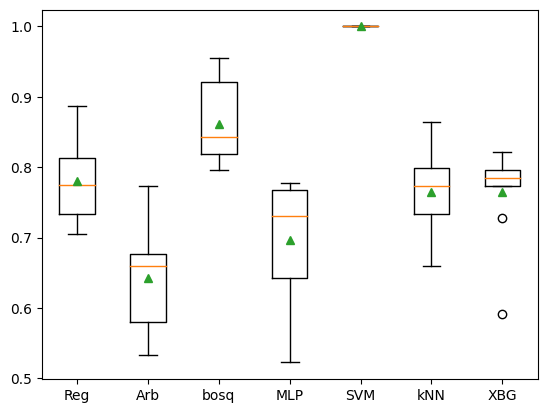

In [ ]:
plt.boxplot(resultados, labels = nombres, showmeans = True)
plt.show()

Ahora veremos que tan bien predicen los modelos utilizando los datos de prueba.

In [ ]:
modelos, nombres = lista_modelos()
resultados = list()

for i in range(len(modelos)):
    modelos[i].fit(Xtv, np.ravel(ytv))
    y_pred = modelos[i].predict(Xtest)
    f1 = f1_score(ytest,y_pred)
    recall = recall_score(ytest,y_pred)
    cm = confusion_matrix(ytest, y_pred)
    print('>> %s:' % nombres[i])
    print('F1 Score: %.3f' % f1)
    print('Recall: %.3f' % recall)
    print('Confusion Matrix:\n', cm)

>> Reg:
F1 Score: 0.778
Recall: 0.875
Confusion Matrix:
 [[ 5  9]
 [ 3 21]]
>> Arb:
F1 Score: 0.600
Recall: 0.625
Confusion Matrix:
 [[ 3 11]
 [ 9 15]]
>> bosq:
F1 Score: 0.679
Recall: 0.792
Confusion Matrix:
 [[ 1 13]
 [ 5 19]]
>> MLP:
F1 Score: 0.731
Recall: 0.792
Confusion Matrix:
 [[ 5  9]
 [ 5 19]]
>> SVM:
F1 Score: 0.774
Recall: 1.000
Confusion Matrix:
 [[ 0 14]
 [ 0 24]]
>> kNN:
F1 Score: 0.680
Recall: 0.708
Confusion Matrix:
 [[ 5  9]
 [ 7 17]]
>> XBG:
F1 Score: 0.755
Recall: 0.833
Confusion Matrix:
 [[ 5  9]
 [ 4 20]]


Ahora, nos enfocamos solo en los 3 modelos que obtuvieron un mejor equilibrio entre la media y la desviación de la métrica de evaluación accuracy.

### 2.2 XGBoost

Para intentar evitar el sobreajuste del modelo, limitaremos la profundidad de los estimadores a 5 y utilizaremos 200 de ellos.

In [ ]:
modelo_xgb = XGBClassifier(random_state=0, max_depth = 5, learning_rate=0.1,n_estimators=200)
modelo_xgb.fit(Xtv, np.ravel(ytv))

y_train_pred = modelo_xgb.predict(Xtv)

# métricas para el conjunto de entrenamiento
f1_train = f1_score(ytv, y_train_pred)
recall_train = recall_score(ytv, y_train_pred)
cm_train = confusion_matrix(ytv, y_train_pred)
accuracy_train = accuracy_score(ytv, y_train_pred)
report_train = classification_report(ytv, y_train_pred)

print('--- Métricas en el Conjunto de Entrenamiento ---')
print('F1 Score: %.3f' % f1_train)
print('Recall Score: %.3f' % recall_train)
print('Accuracy: %.3f' % accuracy_train)
print('Confusion Matrix:\n', cm_train)
print('Classification Report:\n', report_train)


y_pred = modelo_xgb.predict(Xtest)

# métricas para el conjunto de prueba
f1 = f1_score(ytest, y_pred)
recall = recall_score(ytest, y_pred)
cm = confusion_matrix(ytest, y_pred)
accuracy = accuracy_score(ytest, y_pred)
report = classification_report(ytest, y_pred)

print('--- Métricas en el Conjunto de Prueba ---')
print('F1 Score: %.3f' % f1)
print('Recall: %.3f' % recall)
print('Accuracy: %.3f' % accuracy)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', report)

--- Métricas en el Conjunto de Entrenamiento ---
F1 Score: 1.000
Recall Score: 1.000
Accuracy: 1.000
Confusion Matrix:
 [[121   0]
 [  0 221]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00       221

    accuracy                           1.00       342
   macro avg       1.00      1.00      1.00       342
weighted avg       1.00      1.00      1.00       342

--- Métricas en el Conjunto de Prueba ---
F1 Score: 0.692
Recall: 0.750
Accuracy: 0.579
Confusion Matrix:
 [[ 4 10]
 [ 6 18]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.29      0.33        14
           1       0.64      0.75      0.69        24

    accuracy                           0.58        38
   macro avg       0.52      0.52      0.51        38
weighted avg       0.55      0.58      0.56        38



Como el objetivo es ver la relación entre la variable de salida y el resto de las características, obtenemos ahora las variables más mportantes para el modelo, en una lista ordenada y después graficamente

In [ ]:
importances = modelo_xgb.feature_importances_

# Creamos un DataFrame únicamente para que la visualización esté más ordenada
feature_importance_df = pd.DataFrame({
    'Feature': Xtv.columns,
    'Importance': importances
})

# Ordenamos el DataFrame por importancia de mayor a menor
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                        Feature  Importance
13                                  DX_PRIMARIO    0.091578
6                            PROVEEDOR_FAMILIAR    0.054440
33                      CONDUCTA_SUICIDA_ACTUAL    0.051487
5                                      RELIGION    0.050334
0                                          SEXO    0.046643
12                    INICIO_VIDA_SEXUAL_ACTIVA    0.045333
24           A3g_PENSAMIENTO_INTENCION_SUICIDIO    0.045174
35     B1a_INTENCION_DE_LASTIMARSE_EN_ACCIDENTE    0.042187
9                         ESCOLARIDAD_MAXIMA_PX    0.041009
20                          A3c_HABLA_MAS_LENTA    0.040736
18                       A3a_CAMBIO_PESO_UN_MES    0.035953
4                                  ESTADO_civil    0.035246
15                                  MADRS_TOTAL    0.034589
37                              Riesgo_suicidio    0.034217
11                                      MENARCA    0.033494
10                       AnioS_ESTUDIO_P

<Figure size 1000x800 with 0 Axes>

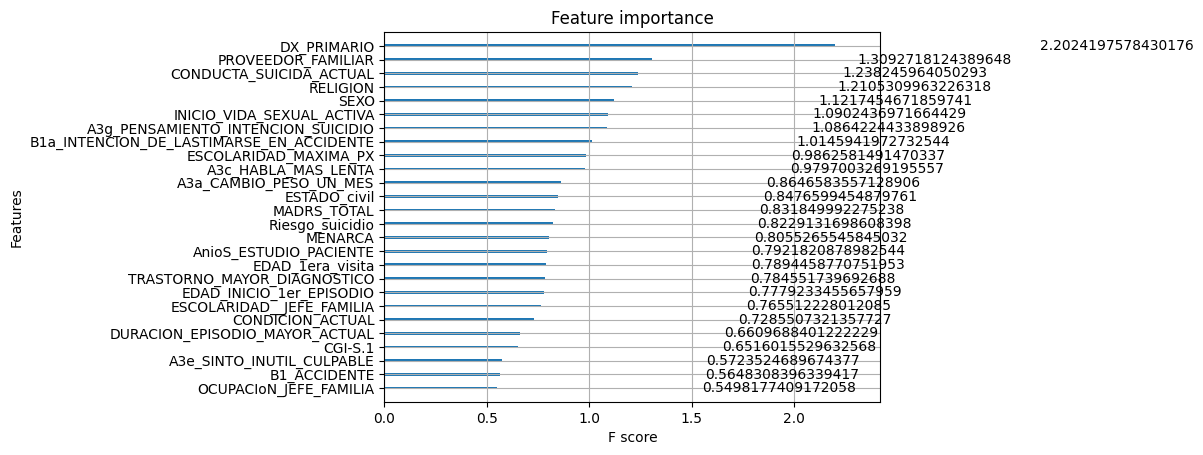

In [ ]:
# Lo mismo pero de manera visual
plt.figure(figsize=(10, 8))
plot_importance(modelo_xgb, importance_type='gain')
plt.show()

### 2.3 Bosque Aleatorio

Para intentar evitar el sobreajuste del modelo, limitaremos la profundidad de los estimadores a 5 y utilizaremos 200 de ellos.

In [ ]:
modelo_rf = RandomForestClassifier(random_state=0, max_depth = 5, n_estimators=200)
modelo_rf.fit(Xtv, np.ravel(ytv))

y_train_pred = modelo_rf.predict(Xtv)

# métricas para el conjunto de entrenamiento
f1_train = f1_score(ytv, y_train_pred)
recall_train = recall_score(ytv, y_train_pred)
cm_train = confusion_matrix(ytv, y_train_pred)
accuracy_train = accuracy_score(ytv, y_train_pred)
report_train = classification_report(ytv, y_train_pred)

print('--- Métricas en el Conjunto de Entrenamiento ---')
print('F1 Score: %.3f' % f1_train)
print('Recall Score: %.3f' % recall_train)
print('Accuracy: %.3f' % accuracy_train)
print('Confusion Matrix:\n', cm_train)
print('Classification Report:\n', report_train)


y_pred = modelo_rf.predict(Xtest)

# métricas para el conjunto de prueba
f1 = f1_score(ytest, y_pred)
recall = recall_score(ytest, y_pred)
cm = confusion_matrix(ytest, y_pred)
accuracy = accuracy_score(ytest, y_pred)
report = classification_report(ytest, y_pred)

print('--- Métricas en el Conjunto de Prueba ---')
print('F1 Score: %.3f' % f1)
print('Recall: %.3f' % recall)
print('Accuracy: %.3f' % accuracy)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', report)

--- Métricas en el Conjunto de Entrenamiento ---
F1 Score: 0.870
Recall Score: 1.000
Accuracy: 0.807
Confusion Matrix:
 [[ 55  66]
 [  0 221]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.45      0.62       121
           1       0.77      1.00      0.87       221

    accuracy                           0.81       342
   macro avg       0.89      0.73      0.75       342
weighted avg       0.85      0.81      0.78       342

--- Métricas en el Conjunto de Prueba ---
F1 Score: 0.754
Recall: 0.958
Accuracy: 0.605
Confusion Matrix:
 [[ 0 14]
 [ 1 23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.62      0.96      0.75        24

    accuracy                           0.61        38
   macro avg       0.31      0.48      0.38        38
weighted avg       0.39      0.61      0.48        38



Al igual que para XGB, obtenemos ahora las variables más mportantes para el modelo, en una lista ordenada.

In [ ]:
importances = modelo_rf.feature_importances_

# Crear un DataFrame para visualizar mejor
feature_importance_df = pd.DataFrame({
    'Feature': Xtv.columns,
    'Importance': importances
})

# Ordenar el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                        Feature  Importance
15                                  MADRS_TOTAL    0.113710
1                              EDAD_1era_visita    0.091349
3                      EDAD_INICIO_1er_EPISODIO    0.086859
29               DURACION_EPISODIO_MAYOR_ACTUAL    0.071530
10                       AnioS_ESTUDIO_PACIENTE    0.067537
12                    INICIO_VIDA_SEXUAL_ACTIVA    0.064140
7                        OCUPACIoN_JEFE_FAMILIA    0.042039
13                                  DX_PRIMARIO    0.040067
32                  TRASTORNO_MAYOR_DIAGNOSTICO    0.037877
6                            PROVEEDOR_FAMILIAR    0.037722
9                         ESCOLARIDAD_MAXIMA_PX    0.035073
8                     ESCOLARIDAD__JEFE_FAMILIA    0.034752
2                              CONDICION_ACTUAL    0.030061
11                                      MENARCA    0.029666
36                         B3_PENSO_EN_SUICIDIO    0.023963
4                                  ESTAD

### 2.4 Regresión logística

In [ ]:
modelo_LR = LogisticRegression(solver='liblinear', random_state=0)
modelo_LR.fit(Xtv, np.ravel(ytv))


y_train_pred = modelo_LR.predict(Xtv)

# métricas para el conjunto de entrenamiento
f1_train = f1_score(ytv, y_train_pred)
recall_train = recall_score(ytv, y_train_pred)
cm_train = confusion_matrix(ytv, y_train_pred)
accuracy_train = accuracy_score(ytv, y_train_pred)
report_train = classification_report(ytv, y_train_pred)

print('--- Métricas en el Conjunto de Entrenamiento ---')
print('F1 Score: %.3f' % f1_train)
print('Recall Score: %.3f' % recall_train)
print('Accuracy: %.3f' % accuracy_train)
print('Confusion Matrix:\n', cm_train)
print('Classification Report:\n', report_train)

y_pred = modelo_LR.predict(Xtest)

# métricas para el conjunto de prueba
f1 = f1_score(ytest, y_pred)
recall = recall_score(ytest, y_pred)
cm = confusion_matrix(ytest, y_pred)
accuracy = accuracy_score(ytest, y_pred)
report = classification_report(ytest, y_pred)

print('--- Métricas en el Conjunto de Prueba ---')
print('F1 Score: %.3f' % f1)
print('Recall: %.3f' % recall)
print('Accuracy: %.3f' % accuracy)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', report)

--- Métricas en el Conjunto de Entrenamiento ---
F1 Score: 0.774
Recall Score: 0.851
Accuracy: 0.678
Confusion Matrix:
 [[ 44  77]
 [ 33 188]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.36      0.44       121
           1       0.71      0.85      0.77       221

    accuracy                           0.68       342
   macro avg       0.64      0.61      0.61       342
weighted avg       0.66      0.68      0.66       342

--- Métricas en el Conjunto de Prueba ---
F1 Score: 0.778
Recall: 0.875
Accuracy: 0.684
Confusion Matrix:
 [[ 5  9]
 [ 3 21]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.36      0.45        14
           1       0.70      0.88      0.78        24

    accuracy                           0.68        38
   macro avg       0.66      0.62      0.62        38
weighted avg       0.67      0.68      0.66        38



In [ ]:
coefficients = modelo_LR.coef_[0]

feature_names = Xtv.columns if hasattr(Xtv, 'columns') else np.arange(Xtv.shape[1])

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Ordenamos las características por valor absoluto del coeficiente
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coef_df)

                                        Feature  Coefficient  Abs_Coefficient
13                                  DX_PRIMARIO     0.535378         0.535378
22                    A3e_SINTO_INUTIL_CULPABLE     0.482586         0.482586
25  A5_INTERVALO_DE_MIN_DOS_MESES_SIN_DEPRESION    -0.389043         0.389043
37                              Riesgo_suicidio    -0.376897         0.376897
30                       TRASTORNO_MAYOR_ACTUAL     0.357082         0.357082
23                 A3f_DIFICULTAD_CONCENTRACION    -0.345253         0.345253
20                          A3c_HABLA_MAS_LENTA     0.332710         0.332710
17                 A2_MENOS_INTERES_DOS_SEMANAS    -0.326751         0.326751
35     B1a_INTENCION_DE_LASTIMARSE_EN_ACCIDENTE     0.314607         0.314607
34                                 B1_ACCIDENTE    -0.305447         0.305447
26              EPISODIO_DEPRESIVO_MAYOR_ACTUAL    -0.299779         0.299779
28          EPISODIO_DEPRESIVO_MAYOR_RECURRENTE     0.294261    

### 2.5 Árbol de decisión

Aunque el árbol de decisión fue uno de los modelos que mostró una mayor desviación estándar en su rendimiento al entrenarse en la validación cruzada, este modelo tiene la ventaja de que podemos ver visualmente el entrenamiento "paso por paso" del modelo. Por lo anterior, también decidimos mostrarlo

In [ ]:
modelo1_df = DecisionTreeClassifier(random_state=0, min_samples_split = 10, max_depth = 5)
modelo1_df.fit(Xtv, np.ravel(ytv))


y_train_pred = modelo1_df.predict(Xtv)

# métricas para el conjunto de entrenamiento
f1_train = f1_score(ytv, y_train_pred)
recall_train = recall_score(ytv, y_train_pred)
cm_train = confusion_matrix(ytv, y_train_pred)
accuracy_train = accuracy_score(ytv, y_train_pred)
report_train = classification_report(ytv, y_train_pred)

print('--- Métricas en el Conjunto de Entrenamiento ---')
print('F1 Score: %.3f' % f1_train)
print('Recall Score: %.3f' % recall_train)
print('Accuracy: %.3f' % accuracy_train)
print('Confusion Matrix:\n', cm_train)
print('Classification Report:\n', report_train)

y_pred = modelo1_df.predict(Xtest)

# métricas para el conjunto de prueba
f1 = f1_score(ytest, y_pred)
recall = recall_score(ytest, y_pred)
cm = confusion_matrix(ytest, y_pred)
accuracy = accuracy_score(ytest, y_pred)
report = classification_report(ytest, y_pred)

print('--- Métricas en el Conjunto de Prueba ---')
print('F1 Score: %.3f' % f1)
print('Recall: %.3f' % recall)
print('Accuracy: %.3f' % accuracy)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', report)

--- Métricas en el Conjunto de Entrenamiento ---
F1 Score: 0.810
Recall Score: 0.937
Accuracy: 0.716
Confusion Matrix:
 [[ 38  83]
 [ 14 207]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.31      0.44       121
           1       0.71      0.94      0.81       221

    accuracy                           0.72       342
   macro avg       0.72      0.63      0.62       342
weighted avg       0.72      0.72      0.68       342

--- Métricas en el Conjunto de Prueba ---
F1 Score: 0.691
Recall: 0.792
Accuracy: 0.553
Confusion Matrix:
 [[ 2 12]
 [ 5 19]]
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.14      0.19        14
           1       0.61      0.79      0.69        24

    accuracy                           0.55        38
   macro avg       0.45      0.47      0.44        38
weighted avg       0.49      0.55      0.51        38



In [ ]:
# Exportamos el árbol a un archivo dot
export_graphviz(modelo1_df, out_file='tree.dot',
                feature_names=Xtv.columns,
                class_names=['Class 0', 'Class 1'],  # Ajusta según tus clases
                rounded=True, proportion=False,
                precision=2, filled=True)

# Necesitamos graphviz para visualizar el archivo dot
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph).view()

'Source.gv.pdf'

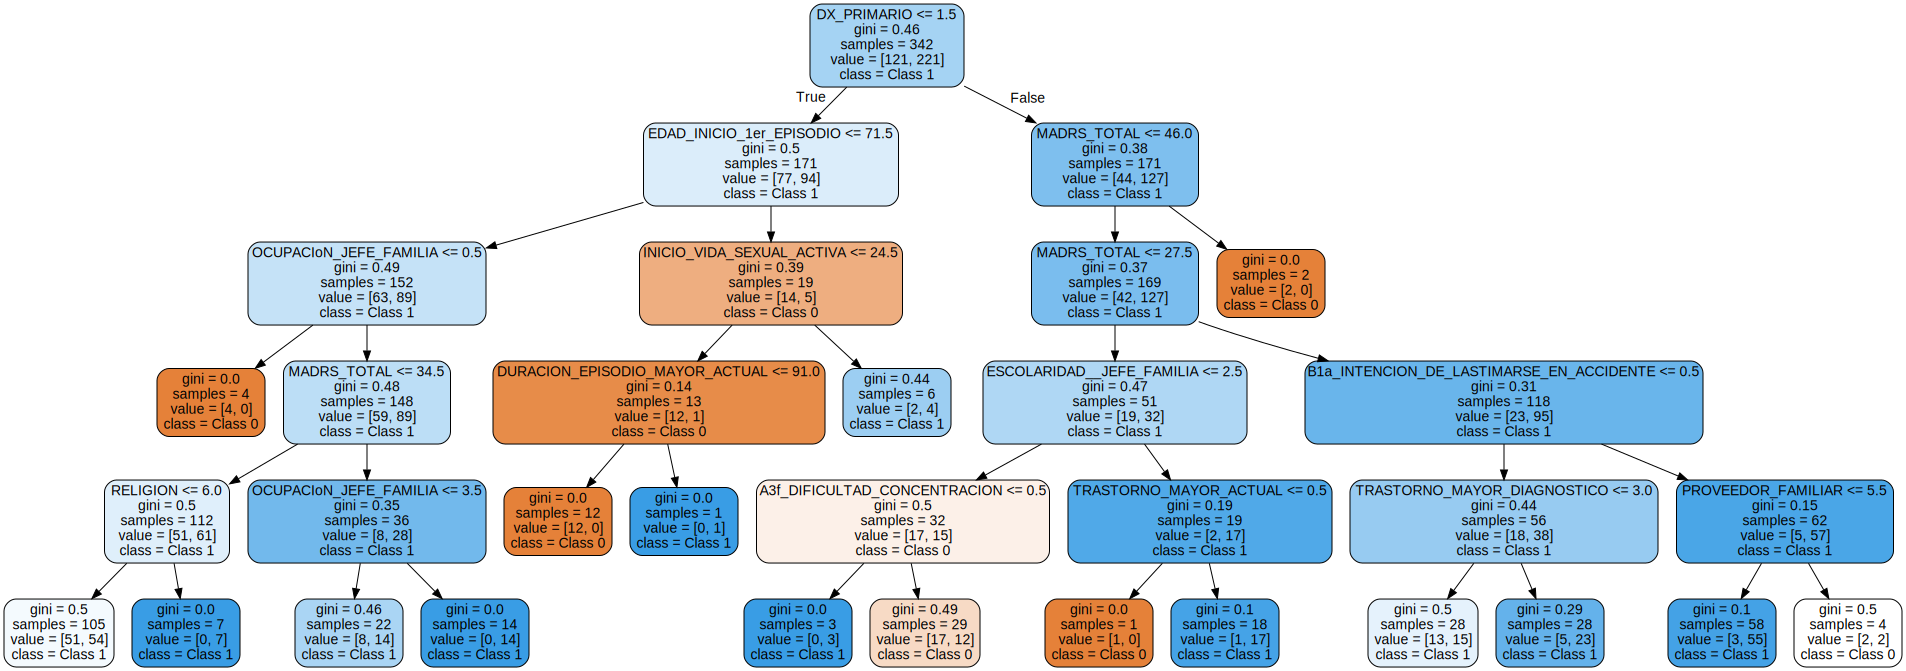

In [ ]:
# Ahora creamos el gráfico
dot_data = export_graphviz(modelo1_df, out_file=None,
                           feature_names=Xtv.columns,
                           class_names=['Class 0', 'Class 1'],  # Ajusta según tus clases
                           rounded=True, proportion=False,
                           precision=2, filled=True)

# Y lo mostramos
grafica = graphviz.Source(dot_data)
display(grafica)

In [ ]:
importances = modelo1_df.feature_importances_

# Crear un DataFrame para visualizar mejor
feature_importance_df = pd.DataFrame({
    'Feature': Xtv.columns,
    'Importance': importances
})

# Ordenar el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                        Feature  Importance
15                                  MADRS_TOTAL    0.164321
13                                  DX_PRIMARIO    0.140633
7                        OCUPACIoN_JEFE_FAMILIA    0.112169
8                     ESCOLARIDAD__JEFE_FAMILIA    0.095545
3                      EDAD_INICIO_1er_EPISODIO    0.077516
35     B1a_INTENCION_DE_LASTIMARSE_EN_ACCIDENTE    0.075342
5                                      RELIGION    0.068378
12                    INICIO_VIDA_SEXUAL_ACTIVA    0.063060
32                  TRASTORNO_MAYOR_DIAGNOSTICO    0.050475
23                 A3f_DIFICULTAD_CONCENTRACION    0.041262
29               DURACION_EPISODIO_MAYOR_ACTUAL    0.040768
30                       TRASTORNO_MAYOR_ACTUAL    0.037321
6                            PROVEEDOR_FAMILIAR    0.033210
26              EPISODIO_DEPRESIVO_MAYOR_ACTUAL    0.000000
27              EPISODIO_DEPRESIVO_MAYOR_PASADO    0.000000
28          EPISODIO_DEPRESIVO_MAYOR_REC

Si tomamos únicamente las 10 características que más aportan a estos 4 modelos, observamos que estas se refieren a: "A3f_DIFICULTAD_CONCENTRACION", "CONDUCTA_SUICIDA_ACTUAL", "DX_PRIMARIO", "A3g_PENSAMIENTO_INTENCION_SUICIDIO", "PROVEEDOR_FAMILIAR", "B1a_INTENCION_DE_LASTIMARSE_EN_ACCIDENTE", "INICIO_VIDA_SEXUAL_ACTIVA", "Riesgo_suicidio", "CONDICION_ACTUAL", "A3a_CAMBIO_PESO_UN_MES", "MADRS_TOTAL", "EDAD_INICIO_1er_EPISODIO", "EDAD_1era_visita", "DURACION_EPISODIO_MAYOR_ACTUAL", "AnioS_ESTUDIO_PACIENTE", "TRASTORNO_MAYOR_DIAGNOSTICO", "OCUPACIoN_JEFE_FAMILIA", "ESCOLARIDAD_MAXIMA_PX", "A3e_SINTO_INUTIL_CULPABLE", "EPISODIO_DEPRESIVO_MAYOR_PASADO", "A2_MENOS_INTERES_DOS_SEMANAS", "TRASTORNO_MAYOR_ACTUAL", "B1_ACCIDENTE", "A3c_HABLA_MAS_LENTA", "A5_INTERVALO_DE_MIN_DOS_MESES_SIN_DEPRESION", "ESCOLARIDAD__JEFE_FAMILIA", "SEXO", "B3_PENSO_EN_SUICIDIO", "ESTADO_civil"

Cabe señalar que, mientras que para árboles de decisión y bosques aleatorios las variables son prácticamente las mismas, esto difiere con respecto a XGBoost y regresión logística

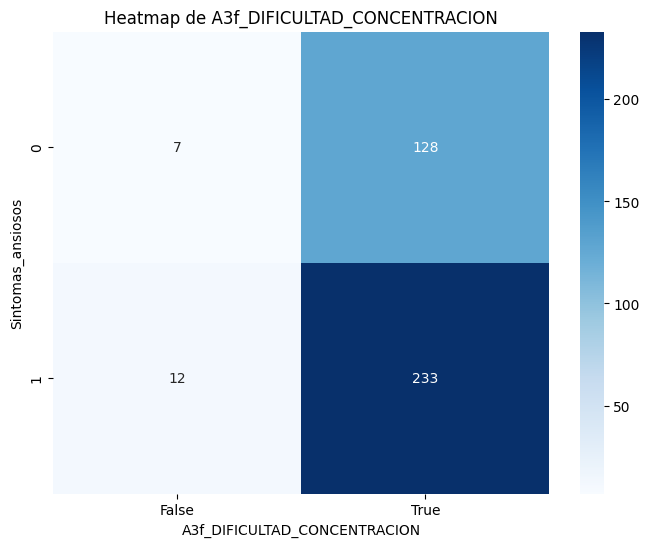

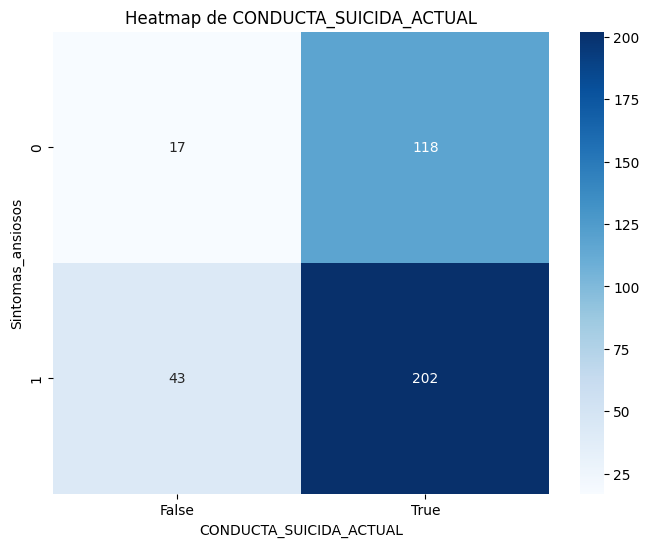

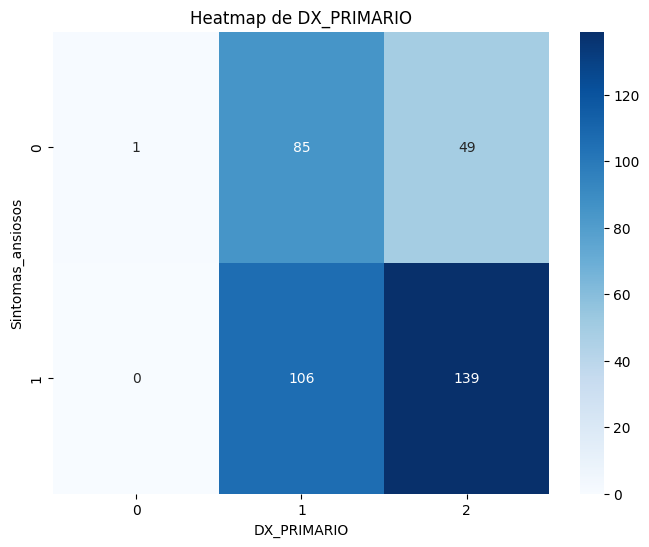

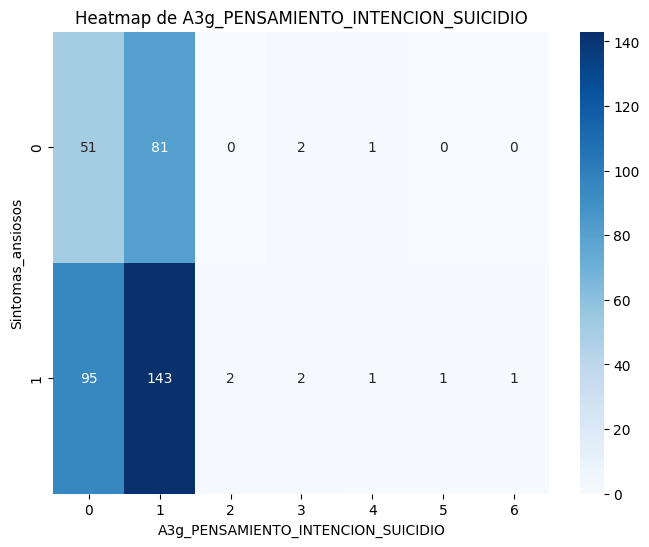

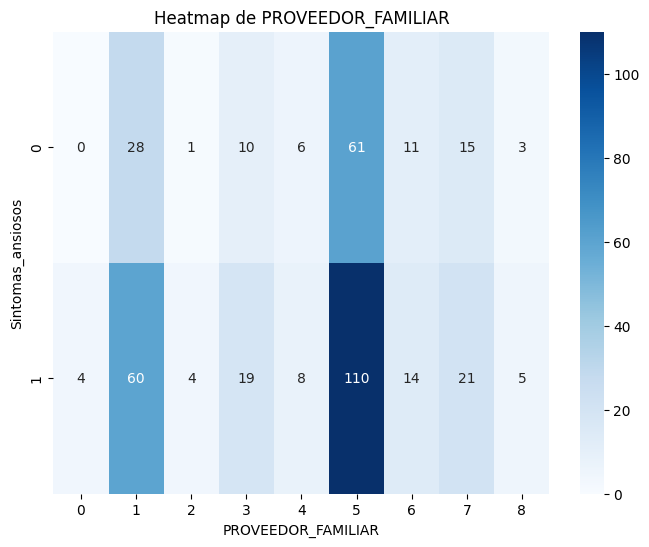

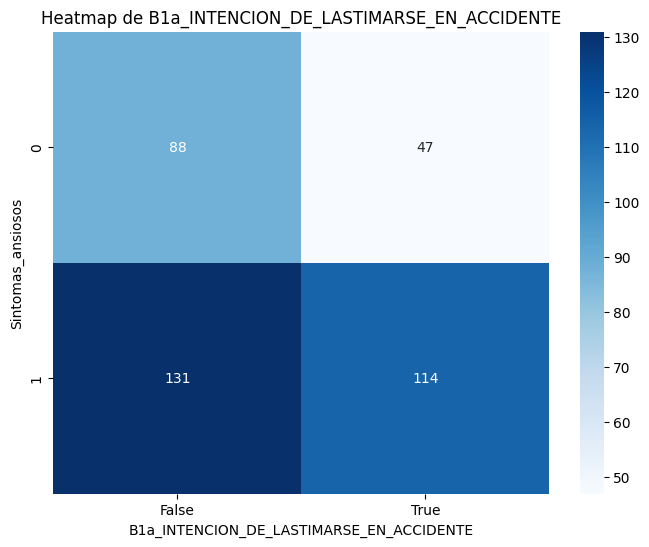

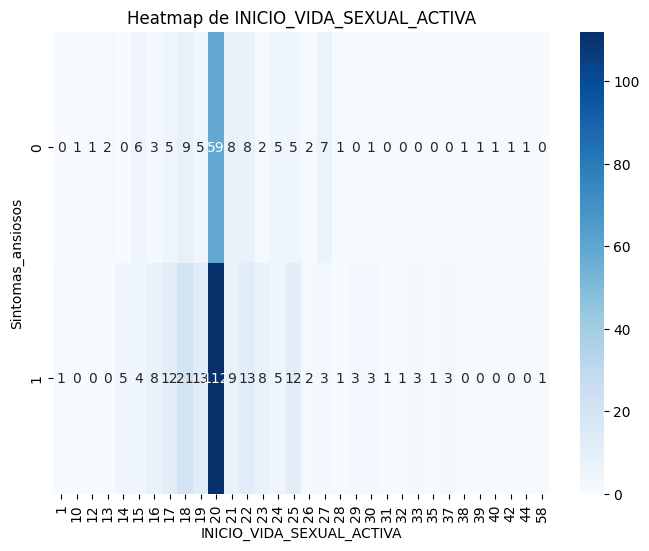

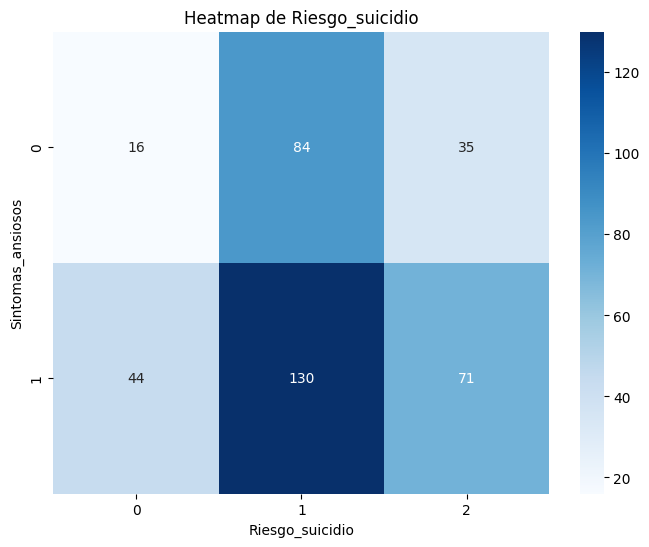

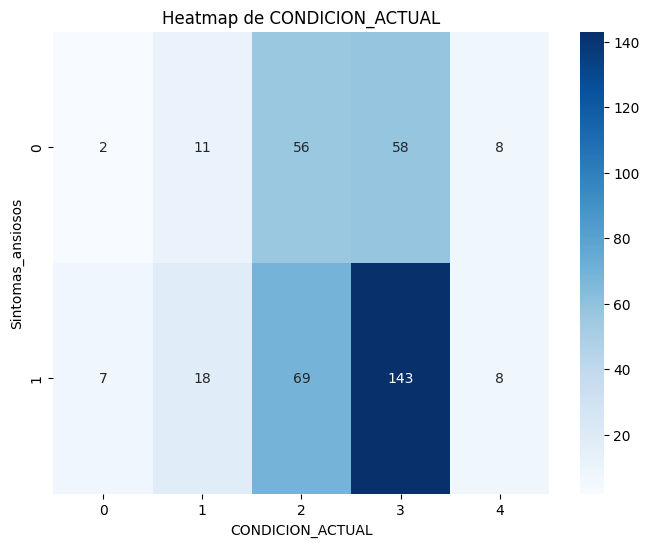

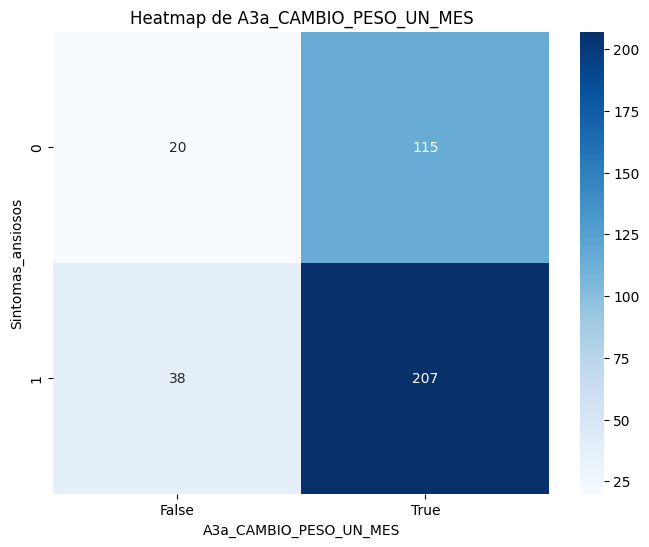

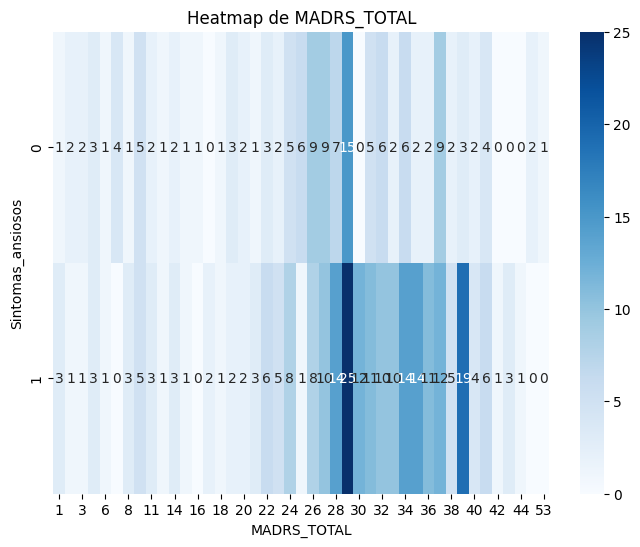

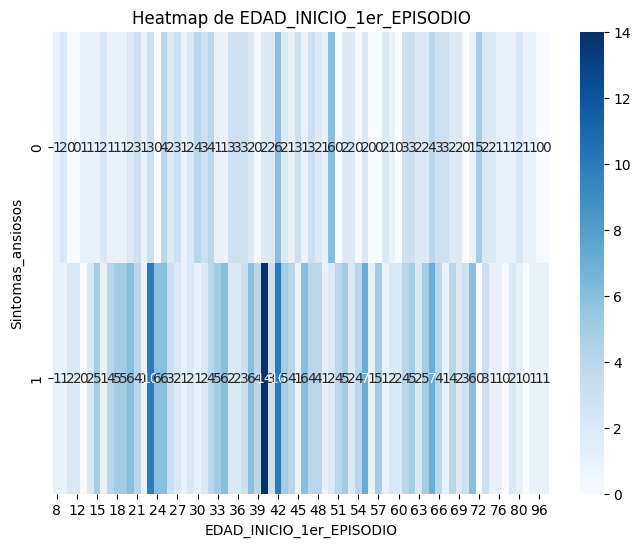

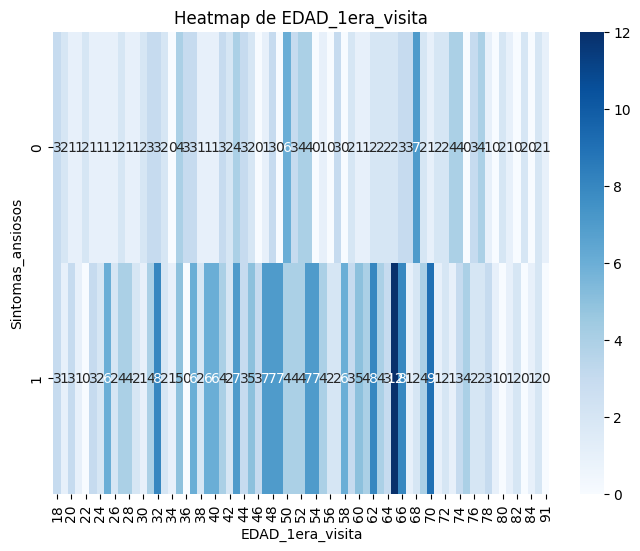

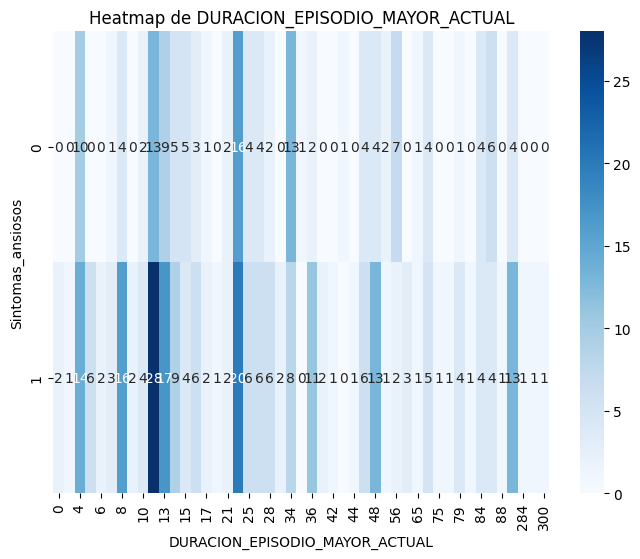

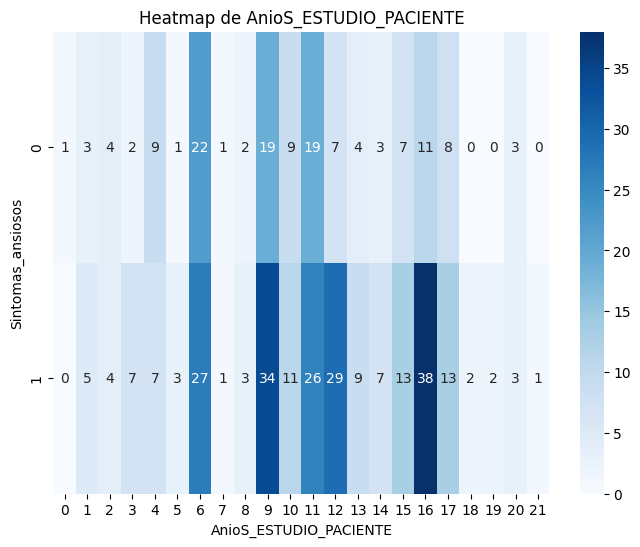

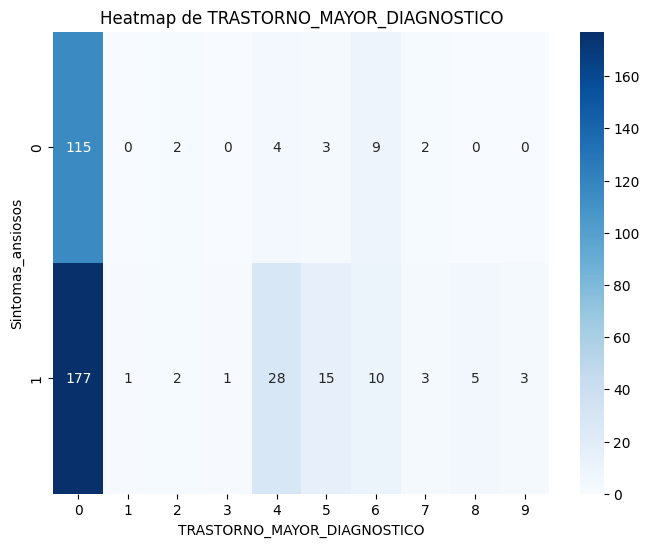

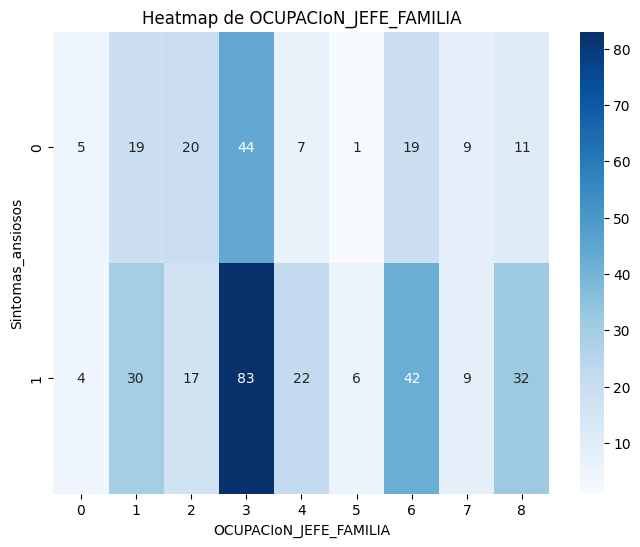

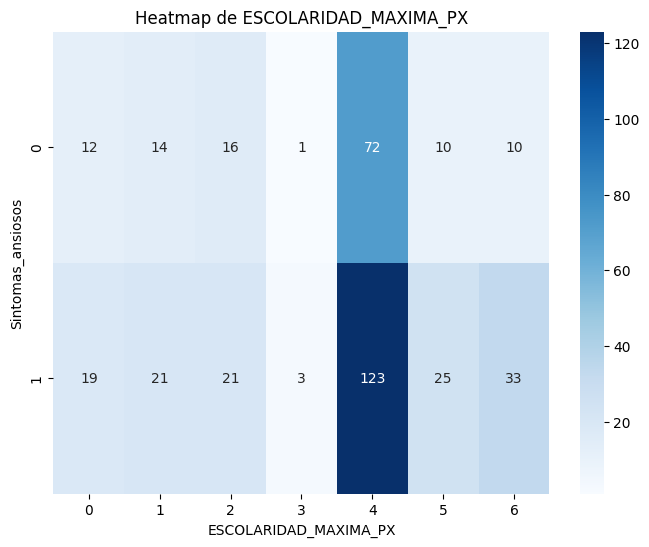

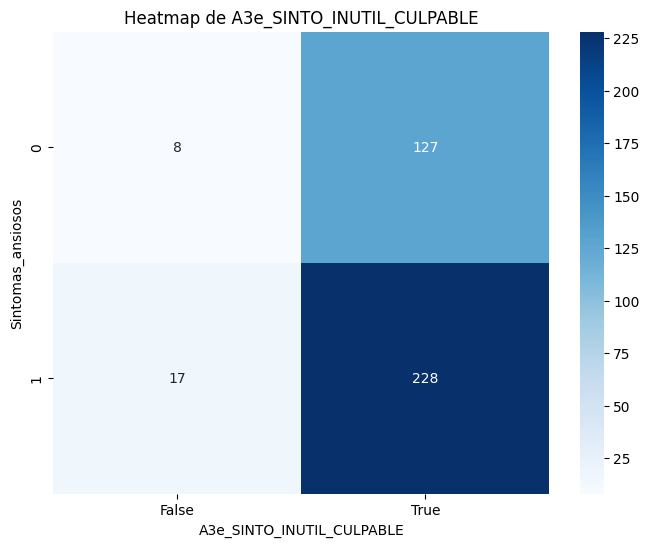

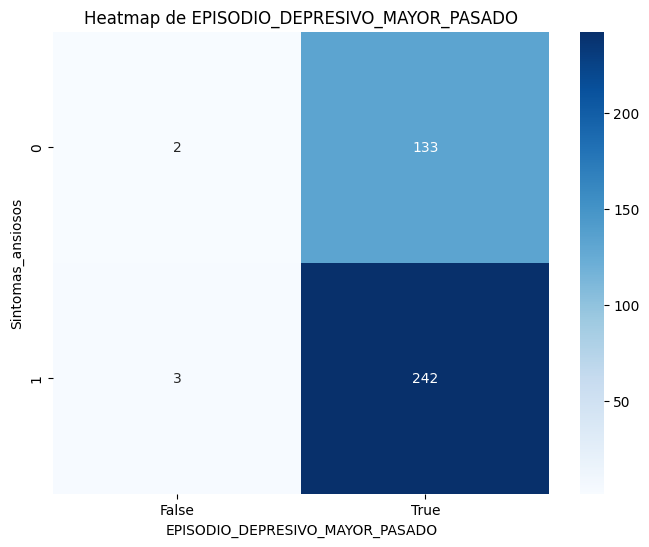

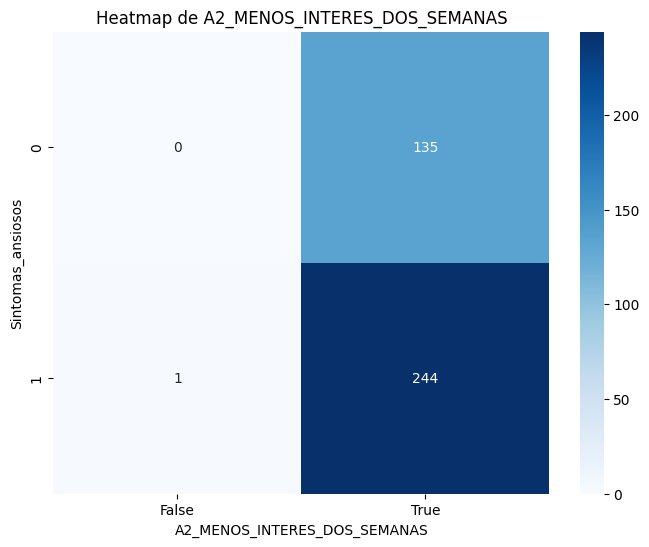

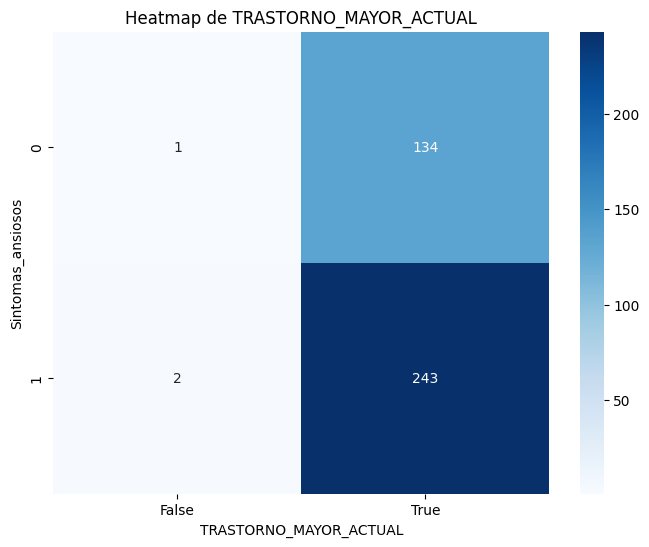

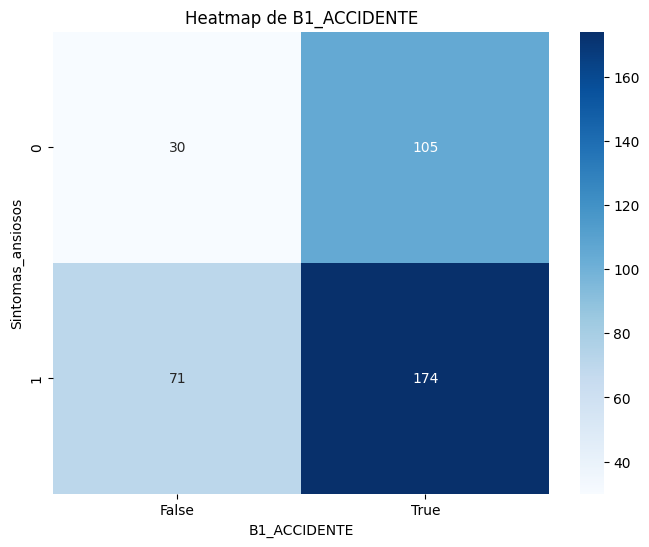

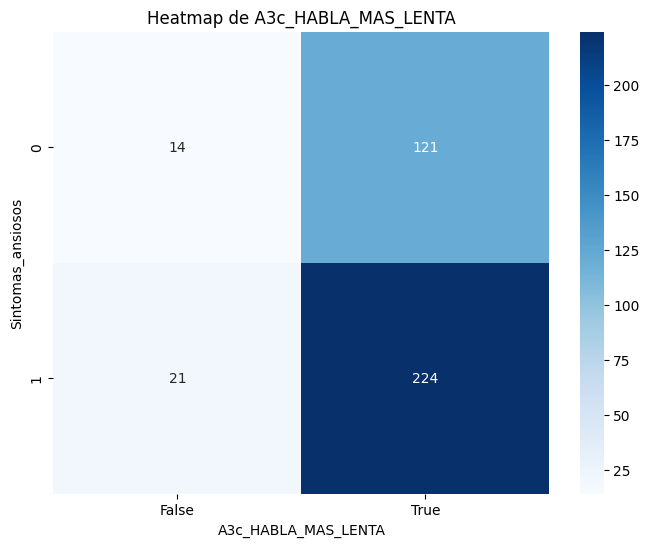

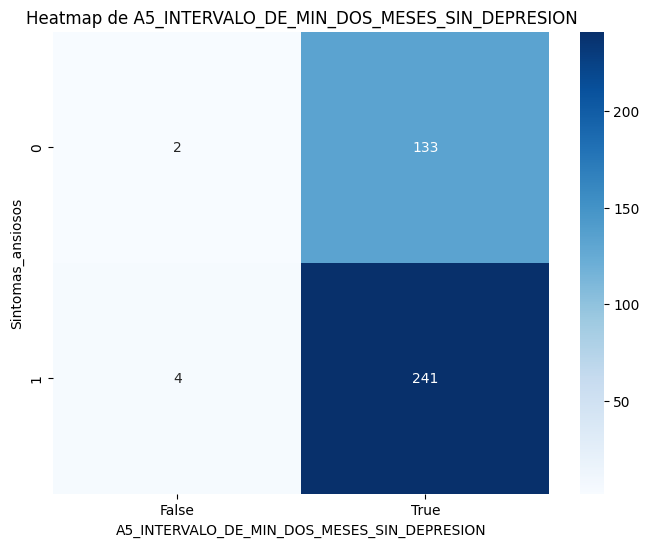

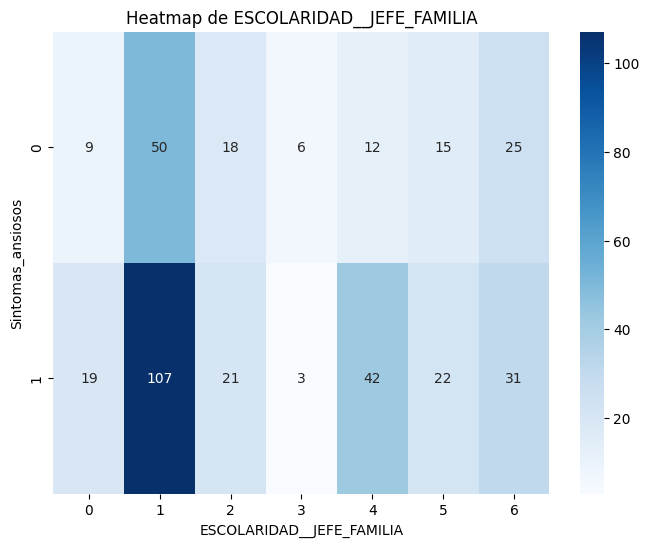

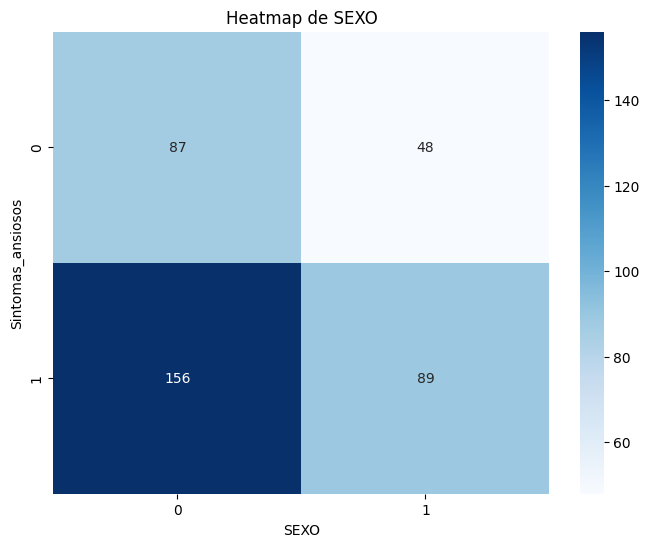

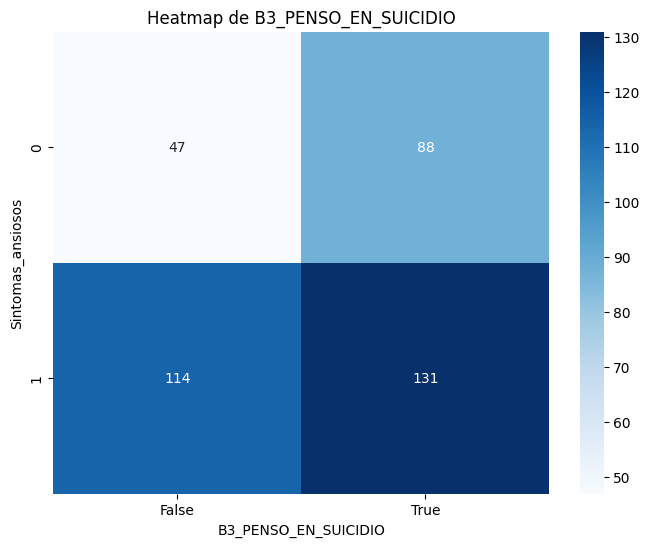

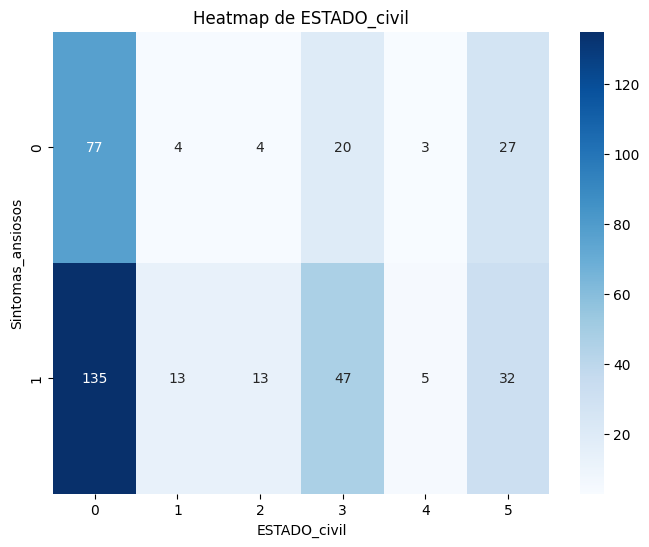

In [ ]:
columnas = ["A3f_DIFICULTAD_CONCENTRACION", "CONDUCTA_SUICIDA_ACTUAL", "DX_PRIMARIO", "A3g_PENSAMIENTO_INTENCION_SUICIDIO",
                    "PROVEEDOR_FAMILIAR", "B1a_INTENCION_DE_LASTIMARSE_EN_ACCIDENTE", "INICIO_VIDA_SEXUAL_ACTIVA", "Riesgo_suicidio",
                    "CONDICION_ACTUAL", "A3a_CAMBIO_PESO_UN_MES", "MADRS_TOTAL", "EDAD_INICIO_1er_EPISODIO", "EDAD_1era_visita", "DURACION_EPISODIO_MAYOR_ACTUAL",
                    "AnioS_ESTUDIO_PACIENTE", "TRASTORNO_MAYOR_DIAGNOSTICO", "OCUPACIoN_JEFE_FAMILIA", "ESCOLARIDAD_MAXIMA_PX", "A3e_SINTO_INUTIL_CULPABLE",
                    "EPISODIO_DEPRESIVO_MAYOR_PASADO", "A2_MENOS_INTERES_DOS_SEMANAS", "TRASTORNO_MAYOR_ACTUAL", "B1_ACCIDENTE", "A3c_HABLA_MAS_LENTA",
                    "A5_INTERVALO_DE_MIN_DOS_MESES_SIN_DEPRESION", "ESCOLARIDAD__JEFE_FAMILIA", "SEXO", "B3_PENSO_EN_SUICIDIO", "ESTADO_civil"]

#for elemento in columnas:
#    plt.figure(figsize=(10, 6))
#    sns.boxplot(data=df, x='Sintomas_ansiosos', y=elemento)
#    plt.title(f'Distribución de {elemento} contra Sintomas_ansiosos')
#    plt.show()


for elemento in columnas:
    # Calcula la matriz de conteo de las combinaciones de valores de A y B
    heatmap_data = df.groupby(['Sintomas_ansiosos', elemento]).size().unstack(fill_value=0)

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='d')
    plt.title(f'Heatmap de {elemento}')
    plt.xlabel(elemento)
    plt.ylabel('Sintomas_ansiosos')
    plt.show()

### 2.6 Anexo

En la gráfica de caja se observa que con SVM todas en todas las iteraciones de la validación cruzada se obtuvo un recall de 1, lo que nos hace suponer que el modelo simplemente se está concentrando en la clase 1 ("moderado-gtave") al no haber falsos negativos, por lo que volvemos a entrenar un SVM pero agregando la condición de las clases balanceadas.  

In [ ]:
modelo_svm = SVC(gamma='scale',class_weight='balanced', random_state=0)
modelo_svm.fit(Xtv, np.ravel(ytv))


y_train_pred = modelo_svm.predict(Xtv)

# métricas para el conjunto de entrenamiento
f1_train = f1_score(ytv, y_train_pred)
recall_train = recall_score(ytv, y_train_pred)
cm_train = confusion_matrix(ytv, y_train_pred)
accuracy_train = accuracy_score(ytv, y_train_pred)
report_train = classification_report(ytv, y_train_pred)

print('--- Métricas en el Conjunto de Entrenamiento ---')
print('F1 Score: %.3f' % f1_train)
print('Recall Score: %.3f' % recall_train)
print('Accuracy: %.3f' % accuracy_train)
print('Confusion Matrix:\n', cm_train)
print('Classification Report:\n', report_train)

y_pred = modelo_svm.predict(Xtest)

# métricas para el conjunto de prueba
f1 = f1_score(ytest, y_pred)
recall = recall_score(ytest, y_pred)
cm = confusion_matrix(ytest, y_pred)
accuracy = accuracy_score(ytest, y_pred)
report = classification_report(ytest, y_pred)

print('--- Métricas en el Conjunto de Prueba ---')
print('F1 Score: %.3f' % f1)
print('Recall: %.3f' % recall)
print('Accuracy: %.3f' % accuracy)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', report)

--- Métricas en el Conjunto de Entrenamiento ---
F1 Score: 0.691
Recall Score: 0.647
Accuracy: 0.626
Confusion Matrix:
 [[ 71  50]
 [ 78 143]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.59      0.53       121
           1       0.74      0.65      0.69       221

    accuracy                           0.63       342
   macro avg       0.61      0.62      0.61       342
weighted avg       0.65      0.63      0.63       342

--- Métricas en el Conjunto de Prueba ---
F1 Score: 0.565
Recall: 0.542
Accuracy: 0.474
Confusion Matrix:
 [[ 5  9]
 [11 13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.36      0.33        14
           1       0.59      0.54      0.57        24

    accuracy                           0.47        38
   macro avg       0.45      0.45      0.45        38
weighted avg       0.49      0.47      0.48        38



## 3 Modelos no supervisados

### 3.1 K-means

K-means es sensible a la escala de los datos de entrada por lo que procedemos a usar MinMaxScaler


In [65]:
# Seleccionar columnas numéricas
df_TC_scaled= df_TC_encoded.copy()
numeric_columns = df_TC_scaled.select_dtypes(include=['number']).columns

# Inicializar el MinMaxScaler
mmscaler = MinMaxScaler()

# Escalar cada columna numérica
for col in numeric_columns:
    df_TC_scaled[col] = mmscaler.fit_transform(df_TC_scaled[[col]])

Porcedemos a usar el algoritmo K-means para encontrar 2 clusters

In [72]:
# Generamos un nuevo dataframe sin la variable de salida
df_clusters = df_TC_scaled.drop(columns=['Sintomas_ansiosos_encoded'])

In [78]:
# Inicializar el modelo KMeans con 10 iteraciones
kmeans = KMeans(init='random', n_clusters=2, n_init=10)

# Ajustar el modelo a los datos
kmeans.fit(df_clusters)

# Predecir el clúster para cada registro
clusters = kmeans.predict(df_clusters)

Revisamos si los nuevos clusters reflejan el nivel de ansiedad

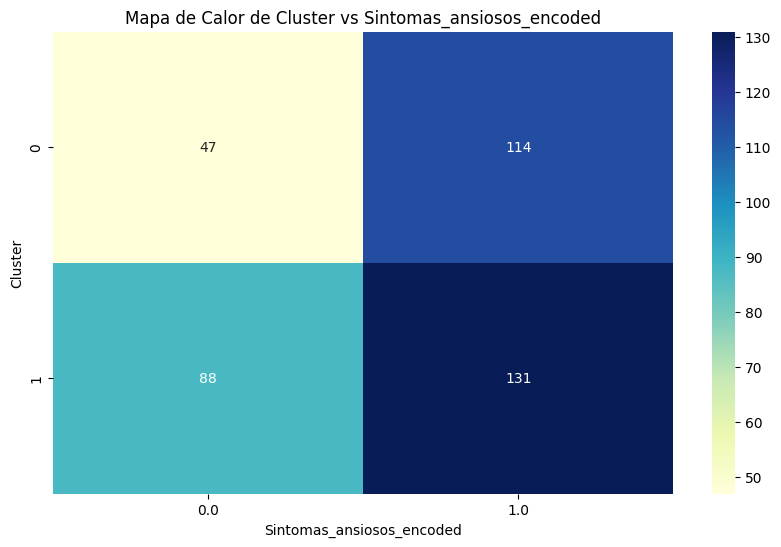

In [79]:
# Combinar las columnas relevantes en un DataFrame
df_combined = pd.DataFrame({
    'cluster': df_clusters['cluster'],
    'Sintomas_ansiosos_encoded': df_TC_scaled['Sintomas_ansiosos_encoded']
})

# Crear una tabla de contingencia
contingency_table = pd.crosstab(df_combined['cluster'], df_combined['Sintomas_ansiosos_encoded'])

# Graficar el mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Mapa de Calor de Cluster vs Sintomas_ansiosos_encoded')
plt.xlabel('Sintomas_ansiosos_encoded')
plt.ylabel('Cluster')
plt.show()

Conclusión K-means:

*   El clúster "0" cuenta con 47 registros con ansiedad leve y 114 registros con ansiedad moderada-alta.
*   El clúster "1" cuenta con 88 registros con ansiedad leve y 131 registros con ansiedad moderada-alta.

Se concluye que los clústeres encontrados no agrupan pacientes de acuerdo a su nivel de ansiedad

Se planea investiga otros algoritmos de clustering para esta aplicación
